In [1]:
!pip install yfinance

In [2]:
!pip install flair

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May  4 15:24:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf
from flair.models import TextClassifier
from flair.data import Sentence

# Import the Dataset and preprocessing


In [5]:
df_orig = pd.read_csv("rWallstreetbetsPosts.csv", low_memory=False)
df_orig.head(3)

,id,title,score,author,author_flair_text,removed_by,total_awards_received,awarders,created_utc,full_link,num_comments,over_18
0,ll0n5k,Whats going on with PLTR?,1,Zaccko98,NaN,moderator,0.0,[],1613469192,https://www.reddit.com/r/wallstreetbets/commen...,2,False
1,ll0n4p,"Need explanations on Level 2 data for GME, why...",1,toutoucnc,210115:1:1,moderator,0.0,[],1613469189,https://www.reddit.com/r/wallstreetbets/commen...,2,False
2,ll0my2,XRT is being used as a laundry short machine,1,thabat,NaN,moderator,0.0,[],1613469166,https://www.reddit.com/r/wallstreetbets/commen...,2,False


In [6]:
df_orig.columns

Index(['id', 'title', 'score', 'author', 'author_flair_text', 'removed_by',
       'total_awards_received', 'awarders', 'created_utc', 'full_link',
       'num_comments', 'over_18'],
      dtype='object')

In [7]:
df_drop = df_orig.drop(columns = ['awarders', 'over_18', 'author_flair_text', 'removed_by','full_link','author'])
df_drop.columns

Index(['id', 'title', 'score', 'total_awards_received', 'created_utc',
       'num_comments'],
      dtype='object')

In [8]:
df_drop.shape

(1118863, 6)

In [9]:
#Was having an issue with a "float" (ended up being a null value) in the title column somehow and had to do a notnull drop of that row
df_clean = df_drop[~df_drop.title.isnull()]
df_clean.shape

(1118862, 6)

In [10]:
df_clean['Date'] = pd.to_datetime(df_clean['created_utc'],unit='s').dt.date
df_clean.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,title,score,total_awards_received,created_utc,num_comments,Date
0,ll0n5k,Whats going on with PLTR?,1,0.0,1613469192,2,2021-02-16
1,ll0n4p,"Need explanations on Level 2 data for GME, why...",1,0.0,1613469189,2,2021-02-16
2,ll0my2,XRT is being used as a laundry short machine,1,0.0,1613469166,2,2021-02-16
3,ll0mxr,Airlines?,1,0.0,1613469165,2,2021-02-16
4,ll0mx4,Buy TRXC 🚀,1,0.0,1613469164,2,2021-02-16
5,ll0mvt,$AMTX,1,0.0,1613469160,2,2021-02-16
6,ll0mpm,Lost 99% of its value....this stock can only g...,1,0.0,1613469134,2,2021-02-16
7,ll0mn2,Bull run AMC ENTERTAINMENT Europe market,1,0.0,1613469125,0,2021-02-16
8,ll0mka,AMC 2 MILLION!!,1,0.0,1613469114,0,2021-02-16
9,ll0krt,Overview of clean Battery Graphite Miners for ...,1,0.0,1613468878,2,2021-02-16


# Flair embedding based sentiment analysis

In [11]:
sentiment_model = TextClassifier.load('en-sentiment')

2022-05-04 15:24:43,172 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


In [12]:

#gets the sentiment and confidence using flair of a specified dataset
def get_sentiment(dataset):
  sentiment = []
  confidence = []

  for sentence in dataset['title']:
    if sentence.strip() == "":
      sentiment.append(0)
      confidence.append(0)
    else:
      sample = Sentence(sentence)
      sentiment_model.predict(sample)
      if sample.labels[0].value == 'POSITIVE':
        sentiment.append(1.0)
      elif sample.labels[0].value == 'NEUTRAL':
        sentiment.append(0.0)
      elif sample.labels[0].value == 'NEGATIVE':
        sentiment.append(-1.0) 
    
      confidence.append(sample.labels[0].score)
  dataset['sentiment'] = sentiment
  dataset['confidence'] = confidence
  return dataset

# Creating multiple datasets for different stocks

In [13]:
df_gme = df_clean[df_clean["title"].str.contains("GME|gme|gamestop|GAMESTOP|Gamestop|Gme|gMe")==True]
df_gme = get_sentiment(df_gme)
df_gme.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(101010, 9)

In [14]:
df_tesla = df_clean[df_clean["title"].str.contains("TSLA|tesla|tsla|TESLA|Tesla")==True]
df_tesla = get_sentiment(df_tesla)
df_tesla.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(21777, 9)

In [15]:
df_amc = df_clean[df_clean["title"].str.contains("amc|AMC|Amc|aMc")==True]
df_amc = get_sentiment(df_amc)
df_amc.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(46831, 9)

In [16]:
df_spy = df_clean[df_clean["title"].str.contains("SPY|spy|Spy|S&P 500|s&p500|s&p 500|S&P500")==True]
df_spy = get_sentiment(df_spy)
df_spy.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(10755, 9)

In [17]:
df_amd = df_clean[df_clean["title"].str.contains("AMD|amd|Amd|Advanced Micro Devices")==True]
df_amd = get_sentiment(df_amd)
df_amd.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(8159, 9)

In [18]:
df_pltr = df_clean[df_clean["title"].str.contains("pltr|PLTR|Palantir|palantir|PALANTIR")==True]
df_pltr = get_sentiment(df_pltr)
df_pltr.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(7305, 9)

In [19]:
df_bb = df_clean[df_clean["title"].str.contains("bb|blackberry|Blackberry|BLACKBERRY|BLACK BERRY|BlackBerry|Black Berry")==True]
df_bb = get_sentiment(df_bb)
df_bb.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(6090, 9)

In [20]:
df_mu = df_clean[df_clean["title"].str.contains("MU|Micron|micron|MICRON")==True]
df_mu = get_sentiment(df_mu)
df_mu.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(7129, 9)

In [21]:
df_apple = df_clean[df_clean["title"].str.contains("apple|APPLE|APPL|appl|Apple")==True]
df_apple = get_sentiment(df_apple)
df_apple.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(4812, 9)

In [22]:
df_amazon = df_clean[df_clean["title"].str.contains("AMZN|amzn|amazon|Amazon|AMAZON")==True]
df_amazon = get_sentiment(df_amazon)
df_amazon.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(5037, 9)

In [23]:
df_snap = df_clean[df_clean["title"].str.contains("SNAP|snap|Snap|snapchat|Snapchat|SNAPCHAT")==True]
df_snap = get_sentiment(df_snap)
print(df_snap.shape)
print(df_snap.dtypes)

(3648, 9)
id                        object
title                     object
score                      int64
total_awards_received    float64
created_utc                int64
num_comments               int64
Date                      object
sentiment                float64
confidence               float64
dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
df_snap.head(5)

,id,title,score,total_awards_received,created_utc,num_comments,Date,sentiment,confidence
1280,lkqc5s,"Let’s buy Snapchat, The ads are whack🤷🏼‍♂️",1,0.0,1613432208,2,2021-02-15,-1.0,0.999933
1356,lkppbp,Chamath finna snap hedge funds out of existence 😎,1,0.0,1613430360,0,2021-02-15,-1.0,0.999814
5159,ljun3r,Cashapp $digmyvibe sucking a wall street guy b...,1,0.0,1613328898,2,2021-02-14,-1.0,0.993348
5167,ljulec,Where is the money at ? Cashapp $digmyvibe sna...,1,0.0,1613328763,0,2021-02-14,-1.0,0.997851
6889,ljgd7l,Get alot of shills in your inboxes? I used to ...,1,0.0,1613273525,2,2021-02-14,-1.0,0.999987


# Function to Get daily averages of the features

In [25]:
# approach to daily averaging adapted from Yifei Huang: https://www.kaggle.com/code/yjh5077/wsbsentimentanalysistest

def get_daily_averages(dataframe):
    df_avg = dataframe
    df_avg_scores = df_avg.groupby(df_avg['Date'])['score','num_comments','sentiment','confidence'].mean()
    df_avg_scores.reset_index(inplace=True)
    return df_avg_scores

df_gme_averages = get_daily_averages(df_gme)
df_gme_averages.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


,Date,score,num_comments,sentiment,confidence
0,2012-06-01,21.0,18.0,1.0,0.659444
1,2013-05-09,3.0,6.0,-1.0,0.998572
2,2014-11-21,2.0,7.0,1.0,0.554342
3,2014-12-10,3.0,8.0,-1.0,0.999920
4,2015-05-29,1.0,8.0,-1.0,0.925611


# Get Market data for those stocks, no stock info on weekends so weekends are lost

In [26]:
# approach to getting market data adapted from Yifei Huang: https://www.kaggle.com/code/yjh5077/wsbsentimentanalysistest

def get_market_data(stock, df, min_date,drop_NaN=True): 
    stockticker = yf.Ticker(stock)
    min_date = pd.to_datetime(min_date).date()
    max_date = max(df.Date)
    hist = stockticker.history(start=min_date, end=max_date)
    
    df_scores_date = df[df.Date > min_date]
    df_scores_date.set_index('Date', inplace=True, drop=True)
    df_wsb = pd.concat([hist, df_scores_date], axis=1)
    
    if drop_NaN: 
        df_wsb = df_wsb.dropna()
    
    return df_wsb

In [27]:
df_gme_stock = get_market_data('GME',df_gme_averages,'2012-06-01',drop_NaN=True)
df_gme_stock.shape

(373, 11)

In [28]:
df_gme_stock.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,score,num_comments,sentiment,confidence
Date,,,,,,,,,,,
2013-05-09,26.217873,26.500468,25.843434,26.203743,3499600.0,0.00,0.0,3.0,6.0,-1.0,0.998572
2014-11-21,29.331107,29.733005,27.619320,28.177511,18761100.0,0.33,0.0,2.0,7.0,1.0,0.554342
2014-12-10,25.855436,25.989399,24.798592,24.806036,5343500.0,0.00,0.0,3.0,8.0,-1.0,0.999920
2015-05-29,33.032041,33.415088,32.386121,32.603931,8682800.0,0.00,0.0,1.0,8.0,-1.0,0.925611
2015-11-23,25.313601,28.789064,25.206664,28.727959,16933800.0,0.00,0.0,1.0,0.0,-1.0,0.999774


In [29]:
#change close and open location in the dataset for easier access to close data in test train split
df_gme_stock = df_gme_stock[['Close','Open','High','Low','Volume','Dividends','Stock Splits','score','num_comments','sentiment','confidence']]
df_gme_stock.head(5)

,Close,Open,High,Low,Volume,Dividends,Stock Splits,score,num_comments,sentiment,confidence
Date,,,,,,,,,,,
2013-05-09,26.203743,26.217873,26.500468,25.843434,3499600.0,0.00,0.0,3.0,6.0,-1.0,0.998572
2014-11-21,28.177511,29.331107,29.733005,27.619320,18761100.0,0.33,0.0,2.0,7.0,1.0,0.554342
2014-12-10,24.806036,25.855436,25.989399,24.798592,5343500.0,0.00,0.0,3.0,8.0,-1.0,0.999920
2015-05-29,32.603931,33.032041,33.415088,32.386121,8682800.0,0.00,0.0,1.0,8.0,-1.0,0.925611
2015-11-23,28.727959,25.313601,28.789064,25.206664,16933800.0,0.00,0.0,1.0,0.0,-1.0,0.999774


# Split train and test and scale for lstm

In [32]:
dataset = df_gme_stock.values

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1)) 

tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    
#reshape the data to needed shape for lstm
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create and fit LSTM model (GME)



In [33]:
#model based off of Stacked LSTM model proposed ny Sharma and Seniaray in 
#"Stock Prediction and Forecasting using Stacked LSTM-Recurrent Neural Network Model"

# Create LSTM model
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

#low learning rate as suggested by Zhang in "Research on Stock Price Prediction Based on PCALSTM Model"
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 128)           131584    
                                                                 
 dropout_2 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               1

In [34]:
model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
39/39 [==============================] - 13s 11ms/step - loss: 5.7028e-04
Epoch 2/40
39/39 [==============================] - 0s 10ms/step - loss: 3.7233e-04
Epoch 3/40
39/39 [==============================] - 0s 10ms/step - loss: 3.1148e-04
Epoch 4/40
39/39 [==============================] - 0s 10ms/step - loss: 3.0147e-04
Epoch 5/40
39/39 [==============================] - 0s 10ms/step - loss: 2.9879e-04
Epoch 6/40
39/39 [==============================] - 0s 11ms/step - loss: 2.9533e-04
Epoch 7/40
39/39 [==============================] - 0s 11ms/step - loss: 2.9165e-04
Epoch 8/40
39/39 [==============================] - 0s 11ms/step - loss: 2.8837e-04
Epoch 9/40
39/39 [==============================] - 0s 10ms/step - loss: 2.8968e-04
Epoch 10/40
39/39 [==============================] - 0s 9ms/step - loss: 2.8357e-04
Epoch 11/40
39/39 [==============================] - 0s 11ms/step - loss: 2.8057e-04
Epoch 12/40
39/39 [==============================] - 0s 10ms/step - loss: 

In [35]:
#testing results
test_1 = model.predict(X_test_scale)
testScore_1 = np.sqrt(mean_squared_error(y_test[:], test_1[:,0]))

#training results
train_1 = model.predict(X_train_scale)
trainScore_1 = np.sqrt(mean_squared_error(y_train[:], train_1[:,0]))

# GME without text sentiment

In [36]:
# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-2])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
39/39 [==============================] - 9s 10ms/step - loss: 5.7104e-04
Epoch 2/40
39/39 [==============================] - 0s 11ms/step - loss: 3.7913e-04
Epoch 3/40
39/39 [==============================] - 0s 10ms/step - loss: 3.0939e-04
Epoch 4/40
39/39 [==============================] - 0s 10ms/step - loss: 2.9168e-04
Epoch 5/40
39/39 [==============================] - 0s 11ms/step - loss: 2.9247e-04
Epoch 6/40
39/39 [==============================] - 0s 11ms/step - loss: 2.8930e-04
Epoch 7/40
39/39 [==============================] - 0s 11ms/step - loss: 2.8705e-04
Epoch 8/40
39/39 [==============================] - 0s 10ms/step - loss: 2.8466e-04
Epoch 9/40
39/39 [==============================] - 0s 11ms/step - loss: 2.8084e-04
Epoch 10/40
39/39 [==============================] - 0s 9ms/step - loss: 2.7569e-04
Epoch 11/40
39/39 [==============================] - 0s 10ms/step - loss: 2.7071e-04
Epoch 12/40
39/39 [==============================] - 0s 11ms/step - loss: 2

In [37]:
#testing results
test_2 = model.predict(X_test_scale)
testScore_2 = np.sqrt(mean_squared_error(y_test[:], test_2[:,0]))

#training results
train_2 = model.predict(X_train_scale)
trainScore_2 = np.sqrt(mean_squared_error(y_train[:], train_2[:,0]))

# GME only sentiment 

In [38]:

dataset = df_gme_stock[['Close','Open','High','Low','Volume','Dividends','Stock Splits','sentiment','confidence','score','num_comments']].values
dataset

array([[26.20374298, 26.21787312, 26.50046781, ...,  0.99857152,
         3.        ,  6.        ],
       [28.17751122, 29.33110657, 29.73300519, ...,  0.55434191,
         2.        ,  7.        ],
       [24.806036  , 25.85543609, 25.98939946, ...,  0.99992001,
         3.        ,  8.        ],
       ...,
       [51.20000076, 50.77000046, 62.83000183, ...,  0.93345908,
         9.37308869, 60.10550459],
       [51.09999847, 50.00999832, 55.31999969, ...,  0.94403247,
         1.68221574, 31.18658892],
       [52.40000153, 50.75      , 55.24000168, ...,  0.93909084,
         1.00956023, 22.92543021]])

In [39]:
# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-2])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
39/39 [==============================] - 9s 11ms/step - loss: 6.0222e-04
Epoch 2/40
39/39 [==============================] - 0s 11ms/step - loss: 4.0963e-04
Epoch 3/40
39/39 [==============================] - 0s 10ms/step - loss: 3.2302e-04
Epoch 4/40
39/39 [==============================] - 0s 10ms/step - loss: 3.0710e-04
Epoch 5/40
39/39 [==============================] - 0s 11ms/step - loss: 2.9880e-04
Epoch 6/40
39/39 [==============================] - 0s 10ms/step - loss: 2.9986e-04
Epoch 7/40
39/39 [==============================] - 0s 10ms/step - loss: 2.9627e-04
Epoch 8/40
39/39 [==============================] - 0s 9ms/step - loss: 2.9421e-04
Epoch 9/40
39/39 [==============================] - 0s 10ms/step - loss: 2.9266e-04
Epoch 10/40
39/39 [==============================] - 0s 10ms/step - loss: 2.9022e-04
Epoch 11/40
39/39 [==============================] - 0s 10ms/step - loss: 2.9097e-04
Epoch 12/40
39/39 [==============================] - 0s 10ms/step - loss: 2

In [40]:
#testing results
test_3 = model.predict(X_test_scale)
testScore_3 = np.sqrt(mean_squared_error(y_test[:], test_3[:,0]))

#training results
train_3 = model.predict(X_train_scale)
trainScore_3 = np.sqrt(mean_squared_error(y_train[:], train_3[:,0]))

# GME without wallstreetbets info

In [41]:
# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-4])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
39/39 [==============================] - 6s 7ms/step - loss: 6.0452e-04
Epoch 2/40
39/39 [==============================] - 0s 7ms/step - loss: 4.2882e-04
Epoch 3/40
39/39 [==============================] - 0s 7ms/step - loss: 3.3983e-04
Epoch 4/40
39/39 [==============================] - 0s 7ms/step - loss: 3.0952e-04
Epoch 5/40
39/39 [==============================] - 0s 7ms/step - loss: 3.0128e-04
Epoch 6/40
39/39 [==============================] - 0s 7ms/step - loss: 3.0467e-04
Epoch 7/40
39/39 [==============================] - 0s 8ms/step - loss: 3.0007e-04
Epoch 8/40
39/39 [==============================] - 0s 7ms/step - loss: 2.9813e-04
Epoch 9/40
39/39 [==============================] - 0s 8ms/step - loss: 2.9758e-04
Epoch 10/40
39/39 [==============================] - 0s 7ms/step - loss: 2.9447e-04
Epoch 11/40
39/39 [==============================] - 0s 8ms/step - loss: 2.8954e-04
Epoch 12/40
39/39 [==============================] - 0s 7ms/step - loss: 2.9372e-04
E

In [42]:
#testing results
test_4 = model.predict(X_test_scale)
testScore_4 = np.sqrt(mean_squared_error(y_test[:], test_4[:,0]))

#training results
train_4 = model.predict(X_train_scale)
trainScore_4 = np.sqrt(mean_squared_error(y_train[:], train_4[:,0]))

Root mean square error with Only Stock info is 0.07134030338857816
Root mean square error with added WSB Features is 0.06899450469099346
Root mean square error with added Sentiment is 0.09078109792519608
Root mean square error with Both Features is 0.09699063539042645


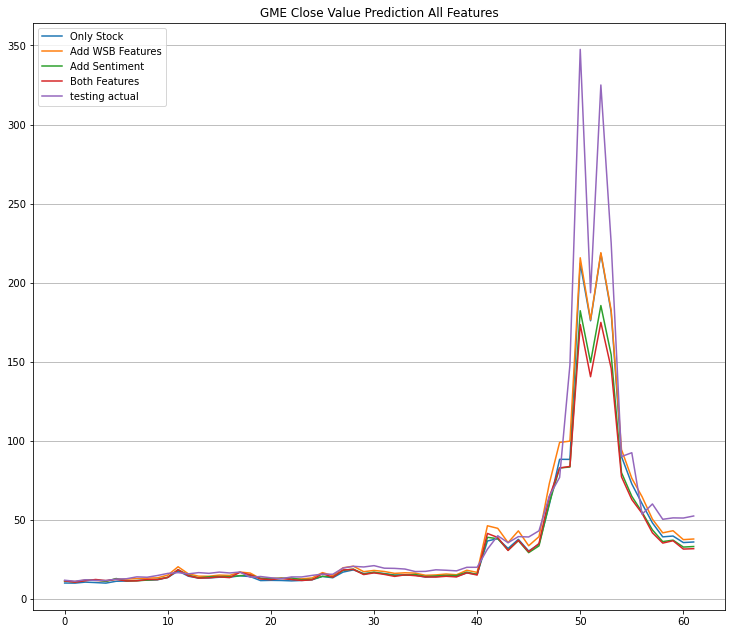

In [43]:
#display testing results
print('Root mean square error with Only Stock info is {}'.format(testScore_4))
print('Root mean square error with added WSB Features is {}'.format(testScore_2))
print('Root mean square error with added Sentiment is {}'.format(testScore_3))
print('Root mean square error with Both Features is {}'.format(testScore_1))

f = plt.figure()
f.set_figwidth(12.4)
f.set_figheight(10.8)
plt.plot(y_MinMax.inverse_transform(test_4),label='Only Stock')
plt.plot(y_MinMax.inverse_transform(test_2),label='Add WSB Features')
plt.plot(y_MinMax.inverse_transform(test_3),label='Add Sentiment')
plt.plot(y_MinMax.inverse_transform(test_1),label='Both Features')
plt.plot(y_MinMax.inverse_transform(y_test),label='testing actual')
plt.title('GME Close Value Prediction All Features')
plt.legend()
plt.grid(axis = 'y')
plt.show()
plt.clf()
plt.cla()
plt.close()

Root mean square error with Only Stock info is 0.007665471085206989
Root mean square error with added WSB Features is 0.009944997345391846
Root mean square error with added Sentiment is 0.01094628884003222
Root mean square error with Both Features is 0.011768766469888451


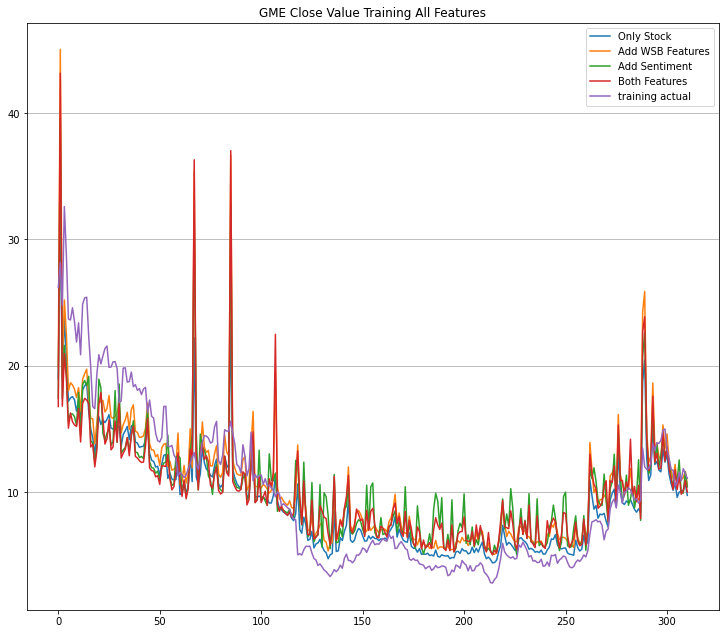

In [44]:
#Display Training Results
print('Root mean square error with Only Stock info is {}'.format(trainScore_4))
print('Root mean square error with added WSB Features is {}'.format(trainScore_2))
print('Root mean square error with added Sentiment is {}'.format(trainScore_3))
print('Root mean square error with Both Features is {}'.format(trainScore_1))

f = plt.figure()
f.set_figwidth(12.4)
f.set_figheight(10.8)
plt.plot(y_MinMax.inverse_transform(train_4),label='Only Stock')
plt.plot(y_MinMax.inverse_transform(train_2),label='Add WSB Features')
plt.plot(y_MinMax.inverse_transform(train_3),label='Add Sentiment')
plt.plot(y_MinMax.inverse_transform(train_1),label='Both Features')
plt.plot(y_MinMax.inverse_transform(y_train),label='training actual')
plt.title('GME Close Value Training All Features')
plt.legend()
plt.grid(axis = 'y')
plt.show()
plt.clf()
plt.cla()
plt.close()

# Tesla

In [45]:
df_tesla

,id,title,score,total_awards_received,created_utc,num_comments,Date,sentiment,confidence
382,lkx6xg,Trendies and Tesla’s are gone. Right as we wer...,1,0.0,1613454584,2,2021-02-16,-1.0,0.525861
553,lkvthp,If you missed out on Mara and riot last year t...,1,0.0,1613449815,1,2021-02-16,-1.0,0.662225
588,lkvlow,Tesla Should Go Bankrupt,0,0.0,1613449036,6,2021-02-16,-1.0,0.998736
713,lkup2a,~$1mil loss Tesla pin risk over the weekend 88...,1,0.0,1613446123,1,2021-02-16,-1.0,0.999949
723,lkum66,Fisker FSR - High Level DD - Primed to be Tesl...,13,1.0,1613445831,46,2021-02-16,1.0,0.999692
...,...,...,...,...,...,...,...,...,...
1118042,1eemkl,Elon Musk leads Tesla's New Stock Offering,5,NaN,1368650458,8,2013-05-15,1.0,0.997998
1118045,1ec1n9,Shorted TSLA via puts,7,NaN,1368560622,33,2013-05-14,-1.0,0.995145
1118046,1ebjiz,Can you guys all short TSLA today?,5,NaN,1368547100,4,2013-05-14,-1.0,0.955341
1118050,1e8s20,Bought ECTY following a post on another sub-re...,3,NaN,1368452836,3,2013-05-13,1.0,0.839577


In [46]:
df_tesla_averages = get_daily_averages(df_tesla)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [47]:
df_tesla_stock = get_market_data('TSLA',df_tesla_averages,'2013-05-09',drop_NaN=True)
df_tesla_stock = df_tesla_stock[['Close','Open','High','Low','Volume','Dividends','Stock Splits','score','num_comments','sentiment','confidence']]

In [48]:
dataset = df_tesla_stock.values

# Scale and split train/test
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1)) 

tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    
#reshape the data to needed shape for lstm
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM model
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
121/121 [==============================] - 6s 9ms/step - loss: 0.0020
Epoch 2/40
121/121 [==============================] - 1s 8ms/step - loss: 7.2245e-04
Epoch 3/40
121/121 [==============================] - 1s 8ms/step - loss: 6.6250e-04
Epoch 4/40
121/121 [==============================] - 1s 8ms/step - loss: 6.1811e-04
Epoch 5/40
121/121 [==============================] - 1s 8ms/step - loss: 5.6465e-04
Epoch 6/40
121/121 [==============================] - 1s 8ms/step - loss: 5.1962e-04
Epoch 7/40
121/121 [==============================] - 1s 8ms/step - loss: 4.4001e-04
Epoch 8/40
121/121 [==============================] - 1s 7ms/step - loss: 3.5756e-04
Epoch 9/40
121/121 [==============================] - 1s 8ms/step - loss: 2.8533e-04
Epoch 10/40
121/121 [==============================] - 1s 8ms/step - loss: 2.3115e-04
Epoch 11/40
121/121 [==============================] - 1s 8ms/step - loss: 2.1146e-04
Epoch 12/40
121/121 [==============================] - 1s 7ms/step 

In [49]:
#testing results
test_1 = model.predict(X_test_scale)
testScore_1 = np.sqrt(mean_squared_error(y_test[:], test_1[:,0]))

#training results
train_1 = model.predict(X_train_scale)
trainScore_1 = np.sqrt(mean_squared_error(y_train[:], train_1[:,0]))

# Tesla Without text sentiment

In [50]:
# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-2])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
121/121 [==============================] - 6s 8ms/step - loss: 0.0024
Epoch 2/40
121/121 [==============================] - 1s 8ms/step - loss: 8.8298e-04
Epoch 3/40
121/121 [==============================] - 1s 7ms/step - loss: 6.8302e-04
Epoch 4/40
121/121 [==============================] - 1s 7ms/step - loss: 6.4026e-04
Epoch 5/40
121/121 [==============================] - 1s 8ms/step - loss: 6.0493e-04
Epoch 6/40
121/121 [==============================] - 1s 7ms/step - loss: 5.4339e-04
Epoch 7/40
121/121 [==============================] - 1s 8ms/step - loss: 4.7135e-04
Epoch 8/40
121/121 [==============================] - 1s 7ms/step - loss: 3.9546e-04
Epoch 9/40
121/121 [==============================] - 1s 8ms/step - loss: 3.1728e-04
Epoch 10/40
121/121 [==============================] - 1s 7ms/step - loss: 2.4356e-04
Epoch 11/40
121/121 [==============================] - 1s 8ms/step - loss: 1.9491e-04
Epoch 12/40
121/121 [==============================] - 1s 7ms/step 

In [51]:
#testing results
test_2 = model.predict(X_test_scale)
testScore_2 = np.sqrt(mean_squared_error(y_test[:], test_2[:,0]))

#training results
train_2 = model.predict(X_train_scale)
trainScore_2 = np.sqrt(mean_squared_error(y_train[:], train_2[:,0]))

# Tesla only sentiment

In [52]:
dataset = df_tesla_stock[['Close','Open','High','Low','Volume','Dividends','Stock Splits','sentiment','confidence','score','num_comments']].values
dataset

array([[1.75599995e+01, 1.61980000e+01, 1.76000004e+01, ...,
        8.39576900e-01, 3.00000000e+00, 3.00000000e+00],
       [1.66480007e+01, 1.88439999e+01, 1.94239998e+01, ...,
        9.75243270e-01, 6.00000000e+00, 1.85000000e+01],
       [1.69680004e+01, 1.63600006e+01, 1.73759995e+01, ...,
        9.97998059e-01, 5.00000000e+00, 8.00000000e+00],
       ...,
       [8.04820007e+02, 8.43640015e+02, 8.44820007e+02, ...,
        9.11955218e-01, 1.26000000e+00, 1.08000000e+00],
       [8.11659973e+02, 8.12440002e+02, 8.29880005e+02, ...,
        9.35817168e-01, 1.01282051e+00, 1.04615385e+01],
       [8.16119995e+02, 8.01260010e+02, 8.17330017e+02, ...,
        9.37271627e-01, 1.00000000e+00, 7.65740741e+00]])

In [53]:
# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-2])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
121/121 [==============================] - 6s 7ms/step - loss: 0.0022
Epoch 2/40
121/121 [==============================] - 1s 8ms/step - loss: 7.8916e-04
Epoch 3/40
121/121 [==============================] - 1s 8ms/step - loss: 6.8896e-04
Epoch 4/40
121/121 [==============================] - 1s 7ms/step - loss: 6.3400e-04
Epoch 5/40
121/121 [==============================] - 1s 8ms/step - loss: 5.8497e-04
Epoch 6/40
121/121 [==============================] - 1s 8ms/step - loss: 5.4150e-04
Epoch 7/40
121/121 [==============================] - 1s 8ms/step - loss: 4.7870e-04
Epoch 8/40
121/121 [==============================] - 1s 8ms/step - loss: 4.2465e-04
Epoch 9/40
121/121 [==============================] - 1s 8ms/step - loss: 3.4967e-04
Epoch 10/40
121/121 [==============================] - 1s 7ms/step - loss: 2.7543e-04
Epoch 11/40
121/121 [==============================] - 1s 7ms/step - loss: 2.2510e-04
Epoch 12/40
121/121 [==============================] - 1s 8ms/step 

In [54]:
#testing results
test_3 = model.predict(X_test_scale)
testScore_3 = np.sqrt(mean_squared_error(y_test[:], test_3[:,0]))

#training results
train_3 = model.predict(X_train_scale)
trainScore_3 = np.sqrt(mean_squared_error(y_train[:], train_3[:,0]))


# Tesla without wallstreetbets info

In [55]:
# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-4])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
121/121 [==============================] - 6s 7ms/step - loss: 0.0025
Epoch 2/40
121/121 [==============================] - 1s 8ms/step - loss: 0.0011
Epoch 3/40
121/121 [==============================] - 1s 7ms/step - loss: 7.5169e-04
Epoch 4/40
121/121 [==============================] - 1s 7ms/step - loss: 7.1582e-04
Epoch 5/40
121/121 [==============================] - 1s 7ms/step - loss: 6.9301e-04
Epoch 6/40
121/121 [==============================] - 1s 7ms/step - loss: 6.6327e-04
Epoch 7/40
121/121 [==============================] - 1s 7ms/step - loss: 6.1838e-04
Epoch 8/40
121/121 [==============================] - 1s 8ms/step - loss: 5.7764e-04
Epoch 9/40
121/121 [==============================] - 1s 7ms/step - loss: 5.3508e-04
Epoch 10/40
121/121 [==============================] - 1s 7ms/step - loss: 4.6067e-04
Epoch 11/40
121/121 [==============================] - 1s 7ms/step - loss: 3.9242e-04
Epoch 12/40
121/121 [==============================] - 1s 7ms/step - lo

In [56]:
#testing results
test_4 = model.predict(X_test_scale)
testScore_4 = np.sqrt(mean_squared_error(y_test[:], test_4[:,0]))

#training results
train_4 = model.predict(X_train_scale)
trainScore_4 = np.sqrt(mean_squared_error(y_train[:], train_4[:,0]))


Root mean square error with Only Stock info is 0.09375522261794406
Root mean square error with added WSB Features is 0.16119720745982777
Root mean square error with added Sentiment is 0.1563972152511017
Root mean square error with Both Features is 0.1806266284564644


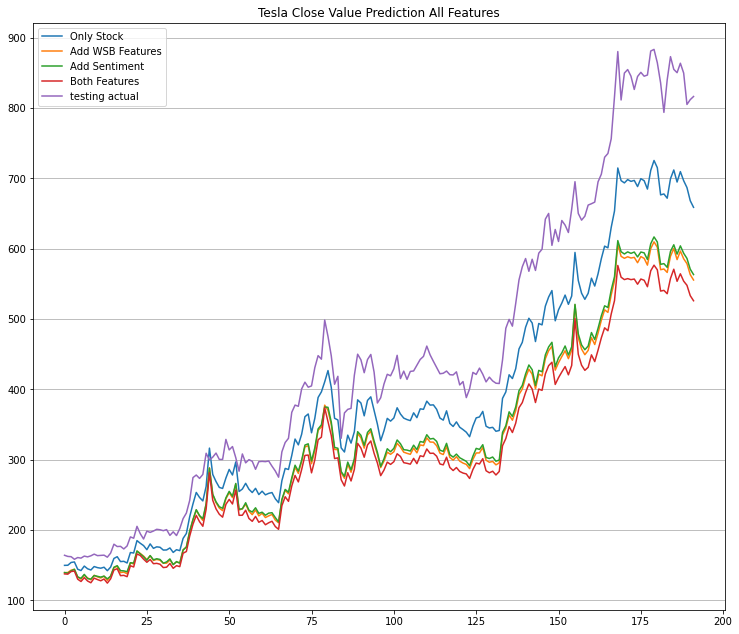

In [57]:
#display testing results
print('Root mean square error with Only Stock info is {}'.format(testScore_4))
print('Root mean square error with added WSB Features is {}'.format(testScore_2))
print('Root mean square error with added Sentiment is {}'.format(testScore_3))
print('Root mean square error with Both Features is {}'.format(testScore_1))

f = plt.figure()
f.set_figwidth(12.4)
f.set_figheight(10.8)
plt.plot(y_MinMax.inverse_transform(test_4),label='Only Stock')
plt.plot(y_MinMax.inverse_transform(test_2),label='Add WSB Features')
plt.plot(y_MinMax.inverse_transform(test_3),label='Add Sentiment')
plt.plot(y_MinMax.inverse_transform(test_1),label='Both Features')
plt.plot(y_MinMax.inverse_transform(y_test),label='testing actual')
plt.title('Tesla Close Value Prediction All Features')
plt.legend()
plt.grid(axis = 'y')
plt.show()
plt.clf()
plt.cla()
plt.close()


Root mean square error of is 0.011136062975385143
Root mean square error of is 0.010039971233149342
Root mean square error of is 0.009714451032786805
Root mean square error of is 0.007449067979335564


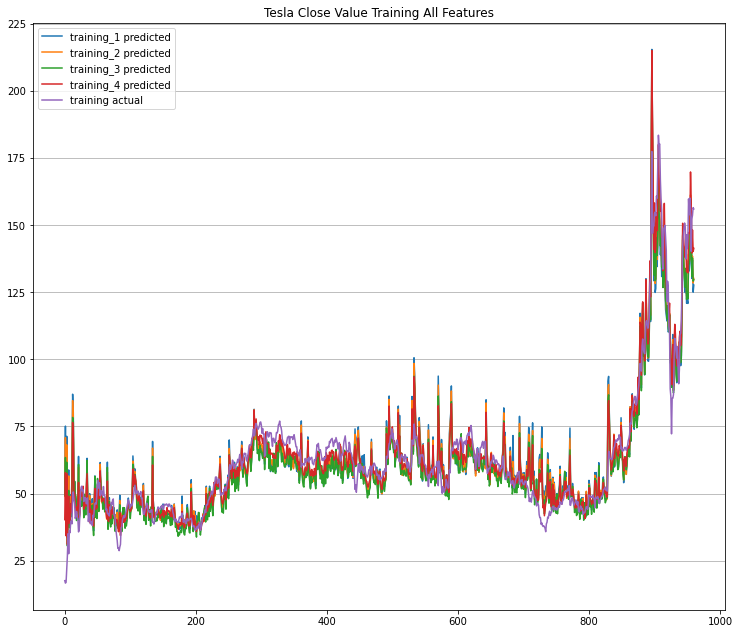

In [58]:
#Display Training Results
print('Root mean square error of is {}'.format(trainScore_1))
print('Root mean square error of is {}'.format(trainScore_2))
print('Root mean square error of is {}'.format(trainScore_3))
print('Root mean square error of is {}'.format(trainScore_4))

f = plt.figure()
f.set_figwidth(12.4)
f.set_figheight(10.8)
plt.plot(y_MinMax.inverse_transform(train_1),label='training_1 predicted')
plt.plot(y_MinMax.inverse_transform(train_2),label='training_2 predicted')
plt.plot(y_MinMax.inverse_transform(train_3),label='training_3 predicted')
plt.plot(y_MinMax.inverse_transform(train_4),label='training_4 predicted')
plt.plot(y_MinMax.inverse_transform(y_train),label='training actual')
plt.title('Tesla Close Value Training All Features')
plt.legend()
plt.grid(axis = 'y')
plt.show()
plt.clf()
plt.cla()
plt.close()


# AMC 

In [59]:
df_amc

,id,title,score,total_awards_received,created_utc,num_comments,Date,sentiment,confidence
7,ll0mn2,Bull run AMC ENTERTAINMENT Europe market,1,0.0,1613469125,0,2021-02-16,-1.0,0.991911
8,ll0mka,AMC 2 MILLION!!,1,0.0,1613469114,0,2021-02-16,-1.0,0.975645
12,ll0k7t,AMC plus 11 percent right now . Germany is hol...,1,0.0,1613468804,0,2021-02-16,1.0,0.964240
20,ll0hnu,AMC 2 MILLION,1,0.0,1613468473,2,2021-02-16,-1.0,0.827020
27,ll0fk7,Amc Tuesday 2 million?,1,0.0,1613468190,2,2021-02-16,-1.0,0.999397
...,...,...,...,...,...,...,...,...,...
1112916,3g9re1,FOSL - Q2 ER '15 AMC on Aug 11 - Time to play?,3,NaN,1439060551,3,2015-08-08,-1.0,0.999702
1113884,3ae5bx,"AMCN, I got downvoted... Today, buyout 70% pre...",14,NaN,1434713515,16,2015-06-19,-1.0,0.905931
1113897,3aaulu,AMCN key entry level right now!,0,NaN,1434645266,7,2015-06-18,1.0,0.999719
1116183,28vjmh,SEEK announced today that they'll be running c...,0,NaN,1403535245,0,2014-06-23,-1.0,0.886424


In [60]:
df_amc_averages = get_daily_averages(df_amc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [61]:
df_amc_stock = get_market_data('AMC',df_amc_averages,'2014-02-24',drop_NaN=True)
df_amc_stock = df_amc_stock[['Close','Open','High','Low','Volume','Dividends','Stock Splits','score','num_comments','sentiment','confidence']]

In [62]:
dataset = df_amc_stock.values

# Scale and split train/test
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1)) 

tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    
#reshape the data to needed shape for lstm
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM model
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
30/30 [==============================] - 5s 8ms/step - loss: 0.1505
Epoch 2/40
30/30 [==============================] - 0s 8ms/step - loss: 0.1433
Epoch 3/40
30/30 [==============================] - 0s 8ms/step - loss: 0.1358
Epoch 4/40
30/30 [==============================] - 0s 8ms/step - loss: 0.1269
Epoch 5/40
30/30 [==============================] - 0s 8ms/step - loss: 0.1167
Epoch 6/40
30/30 [==============================] - 0s 8ms/step - loss: 0.1035
Epoch 7/40
30/30 [==============================] - 0s 7ms/step - loss: 0.0873
Epoch 8/40
30/30 [==============================] - 0s 8ms/step - loss: 0.0704
Epoch 9/40
30/30 [==============================] - 0s 8ms/step - loss: 0.0507
Epoch 10/40
30/30 [==============================] - 0s 7ms/step - loss: 0.0348
Epoch 11/40
30/30 [==============================] - 0s 7ms/step - loss: 0.0245
Epoch 12/40
30/30 [==============================] - 0s 7ms/step - loss: 0.0184
Epoch 13/40
30/30 [==============================

In [63]:
#testing results
test_1 = model.predict(X_test_scale)
testScore_1 = np.sqrt(mean_squared_error(y_test[:], test_1[:,0]))

#training results
train_1 = model.predict(X_train_scale)
trainScore_1 = np.sqrt(mean_squared_error(y_train[:], train_1[:,0]))


# AMC without text seniment

In [64]:
# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-2])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
30/30 [==============================] - 6s 7ms/step - loss: 0.1510
Epoch 2/40
30/30 [==============================] - 0s 8ms/step - loss: 0.1452
Epoch 3/40
30/30 [==============================] - 0s 8ms/step - loss: 0.1387
Epoch 4/40
30/30 [==============================] - 0s 7ms/step - loss: 0.1314
Epoch 5/40
30/30 [==============================] - 0s 7ms/step - loss: 0.1225
Epoch 6/40
30/30 [==============================] - 0s 8ms/step - loss: 0.1123
Epoch 7/40
30/30 [==============================] - 0s 8ms/step - loss: 0.0998
Epoch 8/40
30/30 [==============================] - 0s 7ms/step - loss: 0.0840
Epoch 9/40
30/30 [==============================] - 0s 7ms/step - loss: 0.0687
Epoch 10/40
30/30 [==============================] - 0s 7ms/step - loss: 0.0520
Epoch 11/40
30/30 [==============================] - 0s 8ms/step - loss: 0.0379
Epoch 12/40
30/30 [==============================] - 0s 8ms/step - loss: 0.0268
Epoch 13/40
30/30 [==============================

In [65]:
#testing results
test_2 = model.predict(X_test_scale)
testScore_2 = np.sqrt(mean_squared_error(y_test[:], test_2[:,0]))

#training results
train_2 = model.predict(X_train_scale)
trainScore_2 = np.sqrt(mean_squared_error(y_train[:], train_2[:,0]))


# AMC only sentiment

In [66]:
dataset = df_amc_stock[['Close','Open','High','Low','Volume','Dividends','Stock Splits','sentiment','confidence','score','num_comments']].values

dataset

array([[17.53923416, 17.88755126, 17.88755126, ...,  0.88642365,
         0.        ,  0.        ],
       [22.09366226, 21.5633553 , 22.62397065, ...,  0.99971932,
         0.        ,  7.        ],
       [22.48205376, 22.16835063, 22.58662099, ...,  0.90593106,
        14.        , 16.        ],
       ...,
       [ 5.80000019,  5.71000004,  6.59000015, ...,  0.92316557,
         2.75280899,  4.68820225],
       [ 5.61000013,  5.61999989,  5.8499999 , ...,  0.92462985,
         1.26857143,  3.25142857],
       [ 5.59000015,  5.71999979,  5.96999979, ...,  0.91748812,
         1.        ,  5.64566929]])

In [67]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-2])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
30/30 [==============================] - 5s 8ms/step - loss: 0.1506
Epoch 2/40
30/30 [==============================] - 0s 8ms/step - loss: 0.1443
Epoch 3/40
30/30 [==============================] - 0s 8ms/step - loss: 0.1379
Epoch 4/40
30/30 [==============================] - 0s 7ms/step - loss: 0.1305
Epoch 5/40
30/30 [==============================] - 0s 8ms/step - loss: 0.1212
Epoch 6/40
30/30 [==============================] - 0s 8ms/step - loss: 0.1112
Epoch 7/40
30/30 [==============================] - 0s 8ms/step - loss: 0.0989
Epoch 8/40
30/30 [==============================] - 0s 8ms/step - loss: 0.0835
Epoch 9/40
30/30 [==============================] - 0s 8ms/step - loss: 0.0685
Epoch 10/40
30/30 [==============================] - 0s 8ms/step - loss: 0.0518
Epoch 11/40
30/30 [==============================] - 0s 8ms/step - loss: 0.0370
Epoch 12/40
30/30 [==============================] - 0s 8ms/step - loss: 0.0272
Epoch 13/40
30/30 [==============================

In [68]:
#testing results
test_3 = model.predict(X_test_scale)
testScore_3 = np.sqrt(mean_squared_error(y_test[:], test_3[:,0]))

#training results
train_3 = model.predict(X_train_scale)
trainScore_3 = np.sqrt(mean_squared_error(y_train[:], train_3[:,0]))


# AMC without wallstreetbets info

In [69]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-4])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
30/30 [==============================] - 5s 7ms/step - loss: 0.1518
Epoch 2/40
30/30 [==============================] - 0s 7ms/step - loss: 0.1470
Epoch 3/40
30/30 [==============================] - 0s 7ms/step - loss: 0.1416
Epoch 4/40
30/30 [==============================] - 0s 7ms/step - loss: 0.1356
Epoch 5/40
30/30 [==============================] - 0s 7ms/step - loss: 0.1288
Epoch 6/40
30/30 [==============================] - 0s 7ms/step - loss: 0.1209
Epoch 7/40
30/30 [==============================] - 0s 7ms/step - loss: 0.1119
Epoch 8/40
30/30 [==============================] - 0s 8ms/step - loss: 0.1023
Epoch 9/40
30/30 [==============================] - 0s 7ms/step - loss: 0.0901
Epoch 10/40
30/30 [==============================] - 0s 7ms/step - loss: 0.0770
Epoch 11/40
30/30 [==============================] - 0s 7ms/step - loss: 0.0631
Epoch 12/40
30/30 [==============================] - 0s 8ms/step - loss: 0.0499
Epoch 13/40
30/30 [==============================

In [70]:
#testing results
test_4 = model.predict(X_test_scale)
testScore_4 = np.sqrt(mean_squared_error(y_test[:], test_4[:,0]))

#training results
train_4 = model.predict(X_train_scale)
trainScore_4 = np.sqrt(mean_squared_error(y_train[:], train_4[:,0]))


Root mean square error with Only Stock info is 0.060992743977147074
Root mean square error with added WSB Features is 0.05563754439452638
Root mean square error with added Sentiment is 0.06061432916455734
Root mean square error with Both Features is 0.060348705709052444


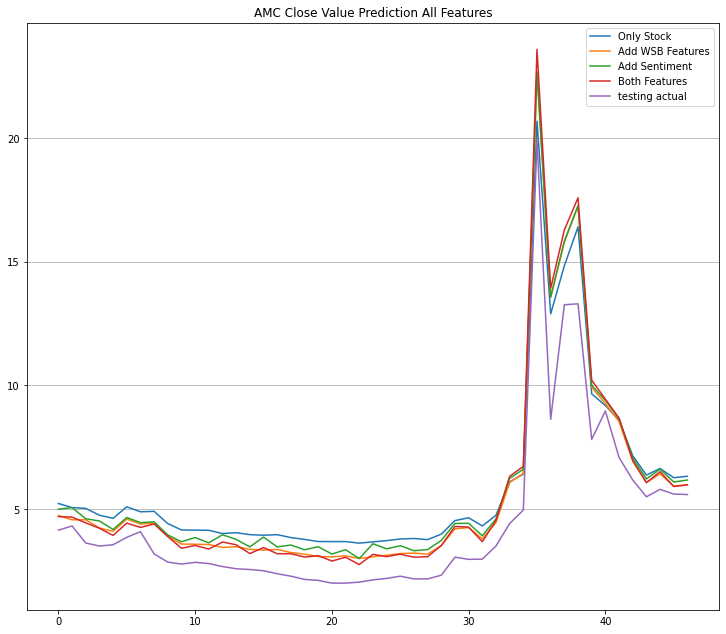

In [71]:
#display testing results
print('Root mean square error with Only Stock info is {}'.format(testScore_4))
print('Root mean square error with added WSB Features is {}'.format(testScore_2))
print('Root mean square error with added Sentiment is {}'.format(testScore_3))
print('Root mean square error with Both Features is {}'.format(testScore_1))

f = plt.figure()
f.set_figwidth(12.4)
f.set_figheight(10.8)
plt.plot(y_MinMax.inverse_transform(test_4),label='Only Stock')
plt.plot(y_MinMax.inverse_transform(test_2),label='Add WSB Features')
plt.plot(y_MinMax.inverse_transform(test_3),label='Add Sentiment')
plt.plot(y_MinMax.inverse_transform(test_1),label='Both Features')
plt.plot(y_MinMax.inverse_transform(y_test),label='testing actual')
plt.title('AMC Close Value Prediction All Features')
plt.legend()
plt.grid(axis = 'y')
plt.show()
plt.clf()
plt.cla()
plt.close()


Root mean square error of is 0.0232331056266325
Root mean square error of is 0.02152305131185674
Root mean square error of is 0.025765224633274388
Root mean square error of is 0.031134385777495267


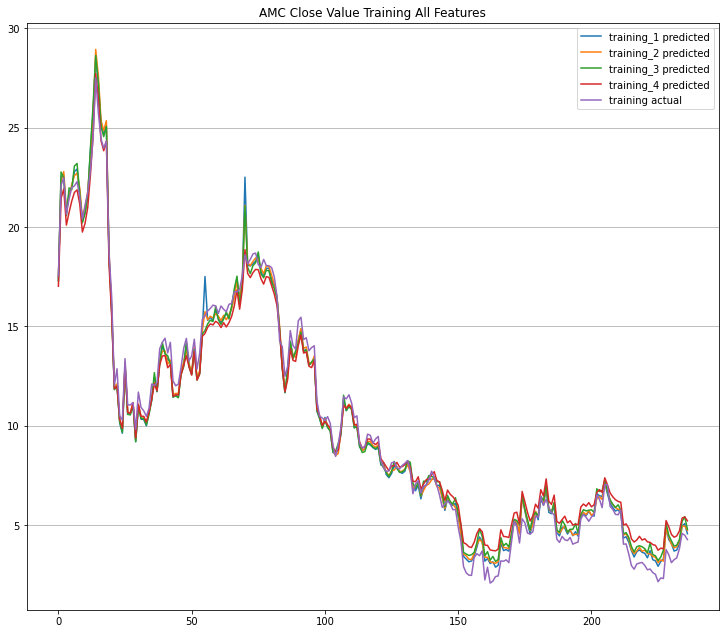

In [72]:
#Display Training Results
print('Root mean square error of is {}'.format(trainScore_1))
print('Root mean square error of is {}'.format(trainScore_2))
print('Root mean square error of is {}'.format(trainScore_3))
print('Root mean square error of is {}'.format(trainScore_4))

f = plt.figure()
f.set_figwidth(12.4)
f.set_figheight(10.8)
plt.plot(y_MinMax.inverse_transform(train_1),label='training_1 predicted')
plt.plot(y_MinMax.inverse_transform(train_2),label='training_2 predicted')
plt.plot(y_MinMax.inverse_transform(train_3),label='training_3 predicted')
plt.plot(y_MinMax.inverse_transform(train_4),label='training_4 predicted')
plt.plot(y_MinMax.inverse_transform(y_train),label='training actual')
plt.title('AMC Close Value Training All Features')
plt.legend()
plt.grid(axis = 'y')
plt.show()
plt.clf()
plt.cla()
plt.close()


# SPY

In [73]:
df_spy

,id,title,score,total_awards_received,created_utc,num_comments,Date,sentiment,confidence
672,lkv06x,SPY Options Release Dates for 2021,1,0.0,1613447092,1,2021-02-16,-1.0,0.907905
1311,lkq3pj,Up over 500% the last 12 months. Made money in...,1,0.0,1613431532,2,2021-02-15,-1.0,0.993834
1654,lknevw,"$SPY has been flat the past week, is this a go...",1,0.0,1613423835,2,2021-02-15,-1.0,0.999977
5039,ljvif6,Lil yatchy⛵ releases new video featuring olive...,1,0.0,1613331376,0,2021-02-14,-1.0,0.989290
5775,ljq2az,Tees to support 45! They are going fast like S...,1,0.0,1613315432,0,2021-02-14,1.0,0.976513
...,...,...,...,...,...,...,...,...,...
1118439,y166m,SPY or IVV,4,NaN,1344655611,7,2012-08-11,-1.0,0.888267
1118440,y0q71,"Inspired by Rexquando, what happens to SPY aft...",6,NaN,1344637098,17,2012-08-10,-1.0,0.990165
1118444,xxut6,Playing the odds: Have not closed 6 days in a...,4,NaN,1344522538,10,2012-08-09,-1.0,0.788258
1118600,vadjr,Just went all-in Short SPY via Puts @ 136.15,9,NaN,1340131810,23,2012-06-19,-1.0,0.999333


In [74]:
df_spy_averages = get_daily_averages(df_spy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [75]:
df_spy_stock = get_market_data('SPY',df_spy_averages,'2012-05-08',drop_NaN=True)
df_spy_stock = df_spy_stock[['Close','Open','High','Low','Volume','Dividends','Stock Splits','score','num_comments','sentiment','confidence']]


In [76]:
dataset = df_spy_stock.values

# Scale and split train/test
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1)) 

tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    
#reshape the data to needed shape for lstm
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM model
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
117/117 [==============================] - 6s 7ms/step - loss: 0.2212
Epoch 2/40
117/117 [==============================] - 1s 7ms/step - loss: 0.1411
Epoch 3/40
117/117 [==============================] - 1s 7ms/step - loss: 0.0298
Epoch 4/40
117/117 [==============================] - 1s 6ms/step - loss: 0.0090
Epoch 5/40
117/117 [==============================] - 1s 6ms/step - loss: 0.0082
Epoch 6/40
117/117 [==============================] - 1s 7ms/step - loss: 0.0077
Epoch 7/40
117/117 [==============================] - 1s 7ms/step - loss: 0.0072
Epoch 8/40
117/117 [==============================] - 1s 7ms/step - loss: 0.0060
Epoch 9/40
117/117 [==============================] - 1s 7ms/step - loss: 0.0055
Epoch 10/40
117/117 [==============================] - 1s 7ms/step - loss: 0.0050
Epoch 11/40
117/117 [==============================] - 1s 7ms/step - loss: 0.0045
Epoch 12/40
117/117 [==============================] - 1s 7ms/step - loss: 0.0038
Epoch 13/40
117/117 [====

In [77]:
#testing results
test_1 = model.predict(X_test_scale)
testScore_1 = np.sqrt(mean_squared_error(y_test[:], test_1[:,0]))

#training results
train_1 = model.predict(X_train_scale)
trainScore_1 = np.sqrt(mean_squared_error(y_train[:], train_1[:,0]))


# SPY without text sentiment

In [78]:
# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-2])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
117/117 [==============================] - 5s 7ms/step - loss: 0.2223
Epoch 2/40
117/117 [==============================] - 1s 6ms/step - loss: 0.1564
Epoch 3/40
117/117 [==============================] - 1s 6ms/step - loss: 0.0464
Epoch 4/40
117/117 [==============================] - 1s 7ms/step - loss: 0.0081
Epoch 5/40
117/117 [==============================] - 1s 6ms/step - loss: 0.0075
Epoch 6/40
117/117 [==============================] - 1s 6ms/step - loss: 0.0066
Epoch 7/40
117/117 [==============================] - 1s 6ms/step - loss: 0.0062
Epoch 8/40
117/117 [==============================] - 1s 7ms/step - loss: 0.0058
Epoch 9/40
117/117 [==============================] - 1s 6ms/step - loss: 0.0054
Epoch 10/40
117/117 [==============================] - 1s 6ms/step - loss: 0.0048
Epoch 11/40
117/117 [==============================] - 1s 7ms/step - loss: 0.0041
Epoch 12/40
117/117 [==============================] - 1s 6ms/step - loss: 0.0038
Epoch 13/40
117/117 [====

In [79]:
#testing results
test_2 = model.predict(X_test_scale)
testScore_2 = np.sqrt(mean_squared_error(y_test[:], test_2[:,0]))

#training results
train_2 = model.predict(X_train_scale)
trainScore_2 = np.sqrt(mean_squared_error(y_train[:], train_2[:,0]))

# SPY only sentiment

In [80]:
dataset = df_spy_stock[['Close','Open','High','Low','Volume','Dividends','Stock Splits','sentiment','confidence','score','num_comments']].values

dataset

array([[1.12771400e+02, 1.12256163e+02, 1.13228472e+02, ...,
        9.99332964e-01, 9.00000000e+00, 2.30000000e+01],
       [1.16851822e+02, 1.16585885e+02, 1.17084511e+02, ...,
        7.88257778e-01, 4.00000000e+00, 1.00000000e+01],
       [1.17042938e+02, 1.16378108e+02, 1.17084493e+02, ...,
        9.90165055e-01, 6.00000000e+00, 1.70000000e+01],
       ...,
       [3.83756470e+02, 3.85763408e+02, 3.85920818e+02, ...,
        9.96647716e-01, 1.00000000e+00, 1.25000000e+00],
       [3.84376282e+02, 3.84897689e+02, 3.85340406e+02, ...,
        9.41483483e-01, 1.00000000e+00, 2.50000000e-01],
       [3.86275024e+02, 3.83530244e+02, 3.86530789e+02, ...,
        9.40118449e-01, 1.00000000e+00, 1.57142857e+00]])

In [81]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-2])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
117/117 [==============================] - 5s 7ms/step - loss: 0.2250
Epoch 2/40
117/117 [==============================] - 1s 7ms/step - loss: 0.1637
Epoch 3/40
117/117 [==============================] - 1s 7ms/step - loss: 0.0564
Epoch 4/40
117/117 [==============================] - 1s 7ms/step - loss: 0.0084
Epoch 5/40
117/117 [==============================] - 1s 7ms/step - loss: 0.0077
Epoch 6/40
117/117 [==============================] - 1s 7ms/step - loss: 0.0071
Epoch 7/40
117/117 [==============================] - 1s 7ms/step - loss: 0.0066
Epoch 8/40
117/117 [==============================] - 1s 7ms/step - loss: 0.0058
Epoch 9/40
117/117 [==============================] - 1s 6ms/step - loss: 0.0050
Epoch 10/40
117/117 [==============================] - 1s 7ms/step - loss: 0.0050
Epoch 11/40
117/117 [==============================] - 1s 6ms/step - loss: 0.0043
Epoch 12/40
117/117 [==============================] - 1s 6ms/step - loss: 0.0038
Epoch 13/40
117/117 [====

In [82]:
#testing results
test_3 = model.predict(X_test_scale)
testScore_3 = np.sqrt(mean_squared_error(y_test[:], test_3[:,0]))

#training results
train_3 = model.predict(X_train_scale)
trainScore_3 = np.sqrt(mean_squared_error(y_train[:], train_3[:,0]))


# SPY without wallstreetbets info

In [83]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-4])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
117/117 [==============================] - 5s 6ms/step - loss: 0.2296
Epoch 2/40
117/117 [==============================] - 1s 6ms/step - loss: 0.1873
Epoch 3/40
117/117 [==============================] - 1s 6ms/step - loss: 0.1086
Epoch 4/40
117/117 [==============================] - 1s 6ms/step - loss: 0.0226
Epoch 5/40
117/117 [==============================] - 1s 6ms/step - loss: 0.0079
Epoch 6/40
117/117 [==============================] - 1s 6ms/step - loss: 0.0077
Epoch 7/40
117/117 [==============================] - 1s 6ms/step - loss: 0.0071
Epoch 8/40
117/117 [==============================] - 1s 6ms/step - loss: 0.0064
Epoch 9/40
117/117 [==============================] - 1s 6ms/step - loss: 0.0056
Epoch 10/40
117/117 [==============================] - 1s 7ms/step - loss: 0.0053
Epoch 11/40
117/117 [==============================] - 1s 6ms/step - loss: 0.0049
Epoch 12/40
117/117 [==============================] - 1s 6ms/step - loss: 0.0042
Epoch 13/40
117/117 [====

In [84]:
#testing results
test_4 = model.predict(X_test_scale)
testScore_4 = np.sqrt(mean_squared_error(y_test[:], test_4[:,0]))

#training results
train_4 = model.predict(X_train_scale)
trainScore_4 = np.sqrt(mean_squared_error(y_train[:], train_4[:,0]))

Root mean square error with Only Stock info is 0.036362907801128296
Root mean square error with added WSB Features is 0.04221315768395527
Root mean square error with added Sentiment is 0.035830358341731865
Root mean square error with Both Features is 0.033068257986417056


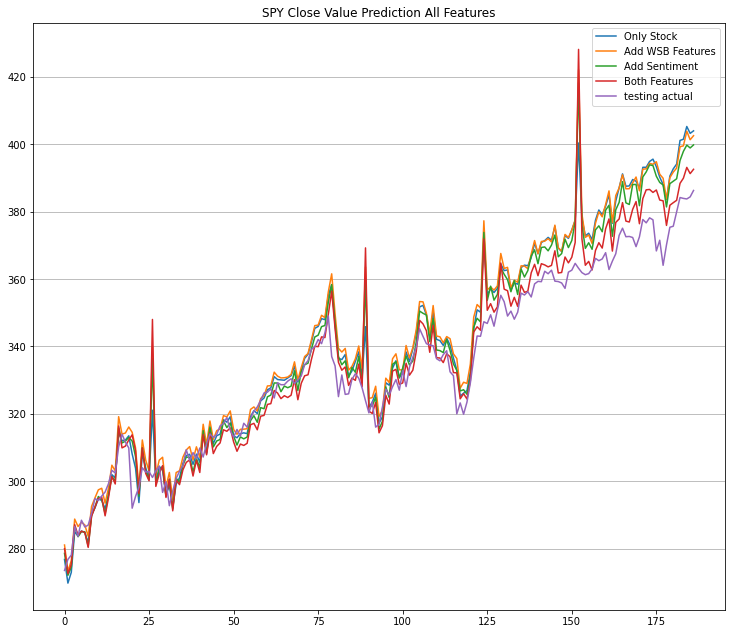

In [85]:
#display testing results
print('Root mean square error with Only Stock info is {}'.format(testScore_4))
print('Root mean square error with added WSB Features is {}'.format(testScore_2))
print('Root mean square error with added Sentiment is {}'.format(testScore_3))
print('Root mean square error with Both Features is {}'.format(testScore_1))

f = plt.figure()
f.set_figwidth(12.4)
f.set_figheight(10.8)
plt.plot(y_MinMax.inverse_transform(test_4),label='Only Stock')
plt.plot(y_MinMax.inverse_transform(test_2),label='Add WSB Features')
plt.plot(y_MinMax.inverse_transform(test_3),label='Add Sentiment')
plt.plot(y_MinMax.inverse_transform(test_1),label='Both Features')
plt.plot(y_MinMax.inverse_transform(y_test),label='testing actual')
plt.title('SPY Close Value Prediction All Features')
plt.legend()
plt.grid(axis = 'y')
plt.show()
plt.clf()
plt.cla()
plt.close()


Root mean square error of is 0.03267117040526375
Root mean square error of is 0.026312263632480196
Root mean square error of is 0.02753148195024689
Root mean square error of is 0.021071231163344063


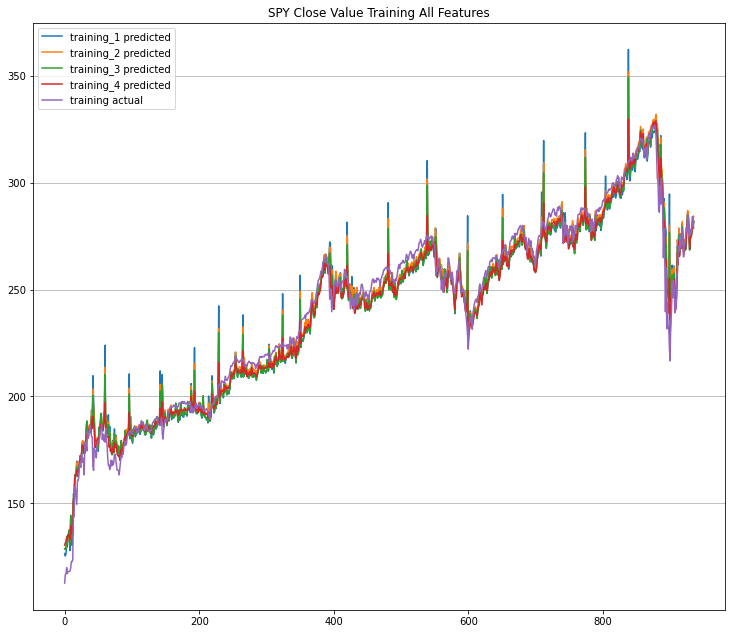

In [86]:
#Display Training Results
print('Root mean square error of is {}'.format(trainScore_1))
print('Root mean square error of is {}'.format(trainScore_2))
print('Root mean square error of is {}'.format(trainScore_3))
print('Root mean square error of is {}'.format(trainScore_4))

f = plt.figure()
f.set_figwidth(12.4)
f.set_figheight(10.8)
plt.plot(y_MinMax.inverse_transform(train_1),label='training_1 predicted')
plt.plot(y_MinMax.inverse_transform(train_2),label='training_2 predicted')
plt.plot(y_MinMax.inverse_transform(train_3),label='training_3 predicted')
plt.plot(y_MinMax.inverse_transform(train_4),label='training_4 predicted')
plt.plot(y_MinMax.inverse_transform(y_train),label='training actual')
plt.title('SPY Close Value Training All Features')
plt.legend()
plt.grid(axis = 'y')
plt.show()
plt.clf()
plt.cla()
plt.close()


# AMD

In [87]:
df_amd

,id,title,score,total_awards_received,created_utc,num_comments,Date,sentiment,confidence
88,lkzwte,"What are you thoughts on AMD, MS and MRK",1,0.0,1613465823,0,2021-02-16,1.0,0.993469
731,lkujx7,AMD strong upside for this week.,7,1.0,1613445651,60,2021-02-16,1.0,0.919886
1183,lkr5ix,AMD 🚀🚀🚀🚀🚀🚀🚀,1,0.0,1613434700,2,2021-02-16,-1.0,0.698641
1688,lkn5wo,First Options and Knock-Outs (AMD &amp; Xiaomi...,1,0.0,1613423158,2,2021-02-15,1.0,0.964870
3287,lkaapd,Why I think AMD is going up a lot soon,1,0.0,1613381973,0,2021-02-15,1.0,0.867600
...,...,...,...,...,...,...,...,...,...
1117801,1l5jux,AMD - Buy call options based on release of XON...,0,NaN,1377563167,2,2013-08-27,-1.0,0.999525
1118011,1f7vic,"As pointed out on /r/gaming, is AMD a good bet...",16,NaN,1369770009,18,2013-05-28,1.0,0.997952
1118337,11ud4g,MSFT and AMD?,5,NaN,1350827224,5,2012-10-21,-1.0,0.990594
1118368,10378k,Falling knife AMD,12,NaN,1347989694,13,2012-09-18,-1.0,0.995385


In [88]:
df_amd_averages = get_daily_averages(df_amd)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [89]:
df_amd_stock = get_market_data('AMD',df_amd_averages,'2012-07-21',drop_NaN=True)
df_amd_stock = df_amd_stock[['Close','Open','High','Low','Volume','Dividends','Stock Splits','score','num_comments','sentiment','confidence']]

In [90]:
dataset = df_amd_stock.values


# Scale and split train/test
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1)) 

tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    
#reshape the data to needed shape for lstm
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM model
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
123/123 [==============================] - 7s 8ms/step - loss: 0.0361
Epoch 2/40
123/123 [==============================] - 1s 8ms/step - loss: 0.0208
Epoch 3/40
123/123 [==============================] - 1s 8ms/step - loss: 0.0106
Epoch 4/40
123/123 [==============================] - 1s 8ms/step - loss: 0.0077
Epoch 5/40
123/123 [==============================] - 1s 8ms/step - loss: 0.0050
Epoch 6/40
123/123 [==============================] - 1s 8ms/step - loss: 0.0025
Epoch 7/40
123/123 [==============================] - 1s 8ms/step - loss: 0.0011
Epoch 8/40
123/123 [==============================] - 1s 8ms/step - loss: 7.9275e-04
Epoch 9/40
123/123 [==============================] - 1s 8ms/step - loss: 7.1600e-04
Epoch 10/40
123/123 [==============================] - 1s 8ms/step - loss: 7.1152e-04
Epoch 11/40
123/123 [==============================] - 1s 8ms/step - loss: 7.6279e-04
Epoch 12/40
123/123 [==============================] - 1s 8ms/step - loss: 7.0480e-04
Epoch

In [91]:
#testing results
test_1 = model.predict(X_test_scale)
testScore_1 = np.sqrt(mean_squared_error(y_test[:], test_1[:,0]))

#training results
train_1 = model.predict(X_train_scale)
trainScore_1 = np.sqrt(mean_squared_error(y_train[:], train_1[:,0]))


# AMD without text sentiment

In [92]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-2])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
123/123 [==============================] - 6s 8ms/step - loss: 0.0371
Epoch 2/40
123/123 [==============================] - 1s 8ms/step - loss: 0.0229
Epoch 3/40
123/123 [==============================] - 1s 8ms/step - loss: 0.0118
Epoch 4/40
123/123 [==============================] - 1s 8ms/step - loss: 0.0087
Epoch 5/40
123/123 [==============================] - 1s 8ms/step - loss: 0.0063
Epoch 6/40
123/123 [==============================] - 1s 8ms/step - loss: 0.0038
Epoch 7/40
123/123 [==============================] - 1s 8ms/step - loss: 0.0018
Epoch 8/40
123/123 [==============================] - 1s 8ms/step - loss: 8.3500e-04
Epoch 9/40
123/123 [==============================] - 1s 8ms/step - loss: 5.9095e-04
Epoch 10/40
123/123 [==============================] - 1s 8ms/step - loss: 5.2741e-04
Epoch 11/40
123/123 [==============================] - 1s 8ms/step - loss: 5.0762e-04
Epoch 12/40
123/123 [==============================] - 1s 8ms/step - loss: 6.1116e-04
Epoch

In [93]:
#testing results
test_2 = model.predict(X_test_scale)
testScore_2 = np.sqrt(mean_squared_error(y_test[:], test_2[:,0]))

#training results
train_2 = model.predict(X_train_scale)
trainScore_2 = np.sqrt(mean_squared_error(y_train[:], train_2[:,0]))


# AMD only sentiment

In [94]:
dataset = df_amd_stock[['Close','Open','High','Low','Volume','Dividends','Stock Splits','sentiment','confidence','score','num_comments']].values

In [95]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-2])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
123/123 [==============================] - 6s 8ms/step - loss: 0.0383
Epoch 2/40
123/123 [==============================] - 1s 7ms/step - loss: 0.0258
Epoch 3/40
123/123 [==============================] - 1s 7ms/step - loss: 0.0136
Epoch 4/40
123/123 [==============================] - 1s 7ms/step - loss: 0.0099
Epoch 5/40
123/123 [==============================] - 1s 7ms/step - loss: 0.0078
Epoch 6/40
123/123 [==============================] - 1s 8ms/step - loss: 0.0050
Epoch 7/40
123/123 [==============================] - 1s 8ms/step - loss: 0.0024
Epoch 8/40
123/123 [==============================] - 1s 8ms/step - loss: 0.0011
Epoch 9/40
123/123 [==============================] - 1s 7ms/step - loss: 6.6433e-04
Epoch 10/40
123/123 [==============================] - 1s 7ms/step - loss: 5.1648e-04
Epoch 11/40
123/123 [==============================] - 1s 7ms/step - loss: 5.5867e-04
Epoch 12/40
123/123 [==============================] - 1s 8ms/step - loss: 5.1901e-04
Epoch 13/

In [96]:
#testing results
test_3 = model.predict(X_test_scale)
testScore_3 = np.sqrt(mean_squared_error(y_test[:], test_3[:,0]))

#training results
train_3 = model.predict(X_train_scale)
trainScore_3 = np.sqrt(mean_squared_error(y_train[:], train_3[:,0]))


# AMD without wallstreetbets info

In [97]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-4])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
123/123 [==============================] - 6s 7ms/step - loss: 0.0383
Epoch 2/40
123/123 [==============================] - 1s 7ms/step - loss: 0.0275
Epoch 3/40
123/123 [==============================] - 1s 7ms/step - loss: 0.0163
Epoch 4/40
123/123 [==============================] - 1s 7ms/step - loss: 0.0111
Epoch 5/40
123/123 [==============================] - 1s 7ms/step - loss: 0.0089
Epoch 6/40
123/123 [==============================] - 1s 8ms/step - loss: 0.0068
Epoch 7/40
123/123 [==============================] - 1s 7ms/step - loss: 0.0043
Epoch 8/40
123/123 [==============================] - 1s 7ms/step - loss: 0.0021
Epoch 9/40
123/123 [==============================] - 1s 7ms/step - loss: 8.6188e-04
Epoch 10/40
123/123 [==============================] - 1s 7ms/step - loss: 4.3831e-04
Epoch 11/40
123/123 [==============================] - 1s 7ms/step - loss: 3.3801e-04
Epoch 12/40
123/123 [==============================] - 1s 7ms/step - loss: 3.5054e-04
Epoch 13/

In [98]:
#testing results
test_4 = model.predict(X_test_scale)
testScore_4 = np.sqrt(mean_squared_error(y_test[:], test_4[:,0]))

#training results
train_4 = model.predict(X_train_scale)
trainScore_4 = np.sqrt(mean_squared_error(y_train[:], train_4[:,0]))


Root mean square error with Only Stock info is 0.05199463385441318
Root mean square error with added WSB Features is 0.05701723939538094
Root mean square error with added Sentiment is 0.06808260263939409
Root mean square error with Both Features is 0.04871459374691005


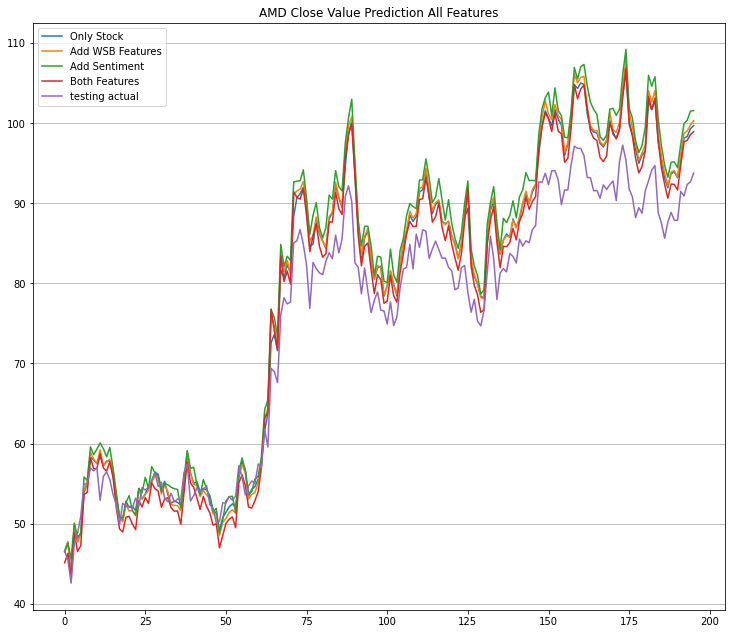

In [99]:
#display testing results
print('Root mean square error with Only Stock info is {}'.format(testScore_4))
print('Root mean square error with added WSB Features is {}'.format(testScore_2))
print('Root mean square error with added Sentiment is {}'.format(testScore_3))
print('Root mean square error with Both Features is {}'.format(testScore_1))

f = plt.figure()
f.set_figwidth(12.4)
f.set_figheight(10.8)
plt.plot(y_MinMax.inverse_transform(test_4),label='Only Stock')
plt.plot(y_MinMax.inverse_transform(test_2),label='Add WSB Features')
plt.plot(y_MinMax.inverse_transform(test_3),label='Add Sentiment')
plt.plot(y_MinMax.inverse_transform(test_1),label='Both Features')
plt.plot(y_MinMax.inverse_transform(y_test),label='testing actual')
plt.title('AMD Close Value Prediction All Features')
plt.legend()
plt.grid(axis = 'y')
plt.show()
plt.clf()
plt.cla()
plt.close()


Root mean square error of is 0.018499847413474053
Root mean square error of is 0.015459433326029764
Root mean square error of is 0.015811361394079796
Root mean square error of is 0.011580870343685308


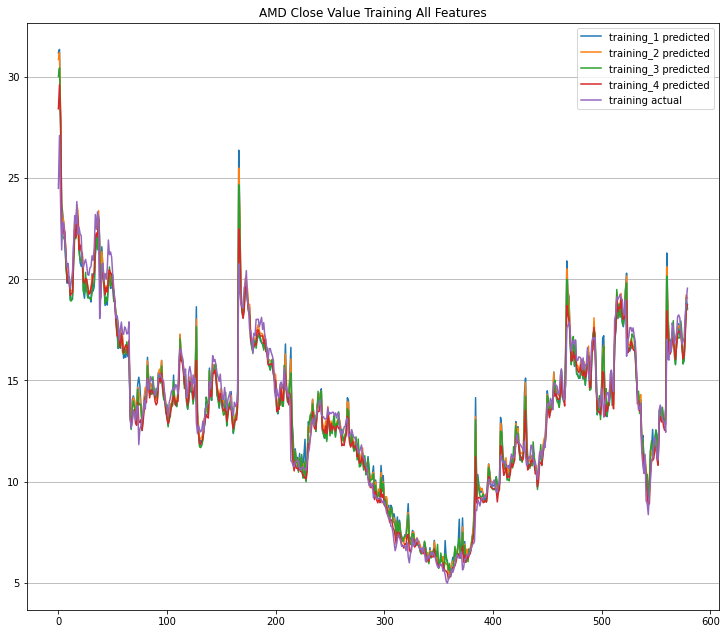

In [185]:
#Display Training Results
print('Root mean square error of is {}'.format(trainScore_1))
print('Root mean square error of is {}'.format(trainScore_2))
print('Root mean square error of is {}'.format(trainScore_3))
print('Root mean square error of is {}'.format(trainScore_4))

f = plt.figure()
f.set_figwidth(12.4)
f.set_figheight(10.8)
plt.plot(y_MinMax.inverse_transform(train_1),label='training_1 predicted')
plt.plot(y_MinMax.inverse_transform(train_2),label='training_2 predicted')
plt.plot(y_MinMax.inverse_transform(train_3),label='training_3 predicted')
plt.plot(y_MinMax.inverse_transform(train_4),label='training_4 predicted')
plt.plot(y_MinMax.inverse_transform(y_train),label='training actual')
plt.title('AMD Close Value Training All Features')
plt.legend()
plt.grid(axis = 'y')
plt.show()
plt.clf()
plt.cla()
plt.close()


# PLTR

In [101]:
df_pltr

,id,title,score,total_awards_received,created_utc,num_comments,Date,sentiment,confidence
0,ll0n5k,Whats going on with PLTR?,1,0.0,1613469192,2,2021-02-16,-1.0,0.995452
31,ll0ete,PLTR next step 🔜 🌕,1,0.0,1613468090,2,2021-02-16,1.0,0.841217
41,ll0a9h,"With all this pumps, I guess I will get some p...",1,0.0,1613467455,2,2021-02-16,1.0,0.999592
51,ll06s7,PLTR TODAY Q4 EARNINGS ✅,1,0.0,1613466989,2,2021-02-16,1.0,0.674342
60,ll05aa,260K worth of stocks plus 60K worth of PLTR op...,1,0.0,1613466788,2,2021-02-16,-1.0,0.988998
...,...,...,...,...,...,...,...,...,...
923997,b24rxx,Palantir IPO. What's yalls opinions?,1,NaN,1552826485,2,2019-03-17,-1.0,0.959943
930614,ameaek,Palantir is filing for an IPO in 2019. In 1 se...,1,NaN,1549116035,46,2019-02-02,-1.0,0.974974
930843,alzjpf,Does anyone find the finance industry boring? ...,1,NaN,1549005262,17,2019-02-01,-1.0,0.999819
1059394,639663,Thoughts on Palantir?,1,NaN,1491249238,11,2017-04-03,1.0,0.530659


In [102]:
df_pltr_averages = get_daily_averages(df_pltr)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [103]:
df_pltr_stock = get_market_data('PLTR',df_pltr_averages,'2017-03-10',drop_NaN=True)
df_pltr_stock = df_pltr_stock[['Close','Open','High','Low','Volume','Dividends','Stock Splits','score','num_comments','sentiment','confidence']]

In [104]:
dataset = df_pltr_stock.values

# Scale and split train/test
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1)) 

tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    
#reshape the data to needed shape for lstm
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM model
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
9/9 [==============================] - 4s 7ms/step - loss: 0.1980
Epoch 2/40
9/9 [==============================] - 0s 6ms/step - loss: 0.1953
Epoch 3/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1926
Epoch 4/40
9/9 [==============================] - 0s 6ms/step - loss: 0.1904
Epoch 5/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1876
Epoch 6/40
9/9 [==============================] - 0s 8ms/step - loss: 0.1849
Epoch 7/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1819
Epoch 8/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1789
Epoch 9/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1758
Epoch 10/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1730
Epoch 11/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1692
Epoch 12/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1660
Epoch 13/40
9/9 [==============================] - 0s 6ms/step - loss: 0.

In [105]:
#testing results
test_1 = model.predict(X_test_scale)
testScore_1 = np.sqrt(mean_squared_error(y_test[:], test_1[:,0]))

#training results
train_1 = model.predict(X_train_scale)
trainScore_1 = np.sqrt(mean_squared_error(y_train[:], train_1[:,0]))


# PLTR without text sentiment

In [106]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-2])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
9/9 [==============================] - 4s 7ms/step - loss: 0.1960
Epoch 2/40
9/9 [==============================] - 0s 8ms/step - loss: 0.1938
Epoch 3/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1917
Epoch 4/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1891
Epoch 5/40
9/9 [==============================] - 0s 6ms/step - loss: 0.1871
Epoch 6/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1846
Epoch 7/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1819
Epoch 8/40
9/9 [==============================] - 0s 6ms/step - loss: 0.1802
Epoch 9/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1768
Epoch 10/40
9/9 [==============================] - 0s 6ms/step - loss: 0.1752
Epoch 11/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1719
Epoch 12/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1686
Epoch 13/40
9/9 [==============================] - 0s 7ms/step - loss: 0.

In [107]:
#testing results
test_2 = model.predict(X_test_scale)
testScore_2 = np.sqrt(mean_squared_error(y_test[:], test_2[:,0]))

#training results
train_2 = model.predict(X_train_scale)
trainScore_2 = np.sqrt(mean_squared_error(y_train[:], train_2[:,0]))


# PLTR only sentiment

In [108]:
dataset = df_pltr_stock[['Close','Open','High','Low','Volume','Dividends','Stock Splits','sentiment','confidence','score','num_comments']].values

In [109]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-2])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
9/9 [==============================] - 4s 7ms/step - loss: 0.1936
Epoch 2/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1914
Epoch 3/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1889
Epoch 4/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1866
Epoch 5/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1837
Epoch 6/40
9/9 [==============================] - 0s 8ms/step - loss: 0.1812
Epoch 7/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1782
Epoch 8/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1759
Epoch 9/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1724
Epoch 10/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1694
Epoch 11/40
9/9 [==============================] - 0s 8ms/step - loss: 0.1665
Epoch 12/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1628
Epoch 13/40
9/9 [==============================] - 0s 7ms/step - loss: 0.

In [110]:
#testing results
test_3 = model.predict(X_test_scale)
testScore_3 = np.sqrt(mean_squared_error(y_test[:], test_3[:,0]))

#training results
train_3 = model.predict(X_train_scale)
trainScore_3 = np.sqrt(mean_squared_error(y_train[:], train_3[:,0]))


# PLTR without wallstreetbets info

In [111]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-4])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
9/9 [==============================] - 4s 7ms/step - loss: 0.1963
Epoch 2/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1944
Epoch 3/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1925
Epoch 4/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1909
Epoch 5/40
9/9 [==============================] - 0s 8ms/step - loss: 0.1891
Epoch 6/40
9/9 [==============================] - 0s 6ms/step - loss: 0.1876
Epoch 7/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1856
Epoch 8/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1837
Epoch 9/40
9/9 [==============================] - 0s 6ms/step - loss: 0.1817
Epoch 10/40
9/9 [==============================] - 0s 6ms/step - loss: 0.1799
Epoch 11/40
9/9 [==============================] - 0s 7ms/step - loss: 0.1781
Epoch 12/40
9/9 [==============================] - 0s 6ms/step - loss: 0.1757
Epoch 13/40
9/9 [==============================] - 0s 6ms/step - loss: 0.

In [112]:
#testing results
test_4 = model.predict(X_test_scale)
testScore_4 = np.sqrt(mean_squared_error(y_test[:], test_4[:,0]))

#training results
train_4 = model.predict(X_train_scale)
trainScore_4 = np.sqrt(mean_squared_error(y_train[:], train_4[:,0]))


Root mean square error with Only Stock info is 0.521110448179758
Root mean square error with added WSB Features is 0.28987610343930836
Root mean square error with added Sentiment is 0.2611282021211931
Root mean square error with Both Features is 0.20535049038105374


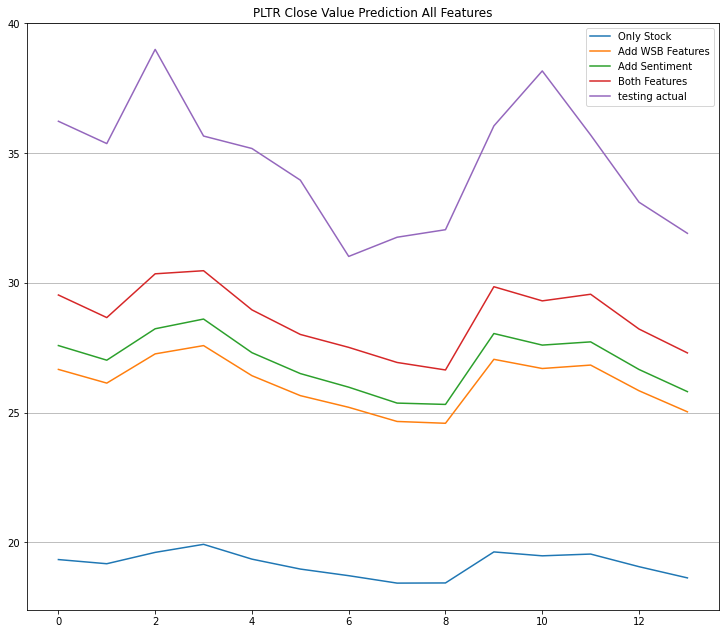

In [113]:
#display testing results
print('Root mean square error with Only Stock info is {}'.format(testScore_4))
print('Root mean square error with added WSB Features is {}'.format(testScore_2))
print('Root mean square error with added Sentiment is {}'.format(testScore_3))
print('Root mean square error with Both Features is {}'.format(testScore_1))

f = plt.figure()
f.set_figwidth(12.4)
f.set_figheight(10.8)
plt.plot(y_MinMax.inverse_transform(test_4),label='Only Stock')
plt.plot(y_MinMax.inverse_transform(test_2),label='Add WSB Features')
plt.plot(y_MinMax.inverse_transform(test_3),label='Add Sentiment')
plt.plot(y_MinMax.inverse_transform(test_1),label='Both Features')
plt.plot(y_MinMax.inverse_transform(y_test),label='testing actual')
plt.title('PLTR Close Value Prediction All Features')
plt.legend()
plt.grid(axis = 'y')
plt.show()
plt.clf()
plt.cla()
plt.close()


Root mean square error of is 0.1355581907919989
Root mean square error of is 0.15124432341258995
Root mean square error of is 0.14589006115548478
Root mean square error of is 0.2397315499575618


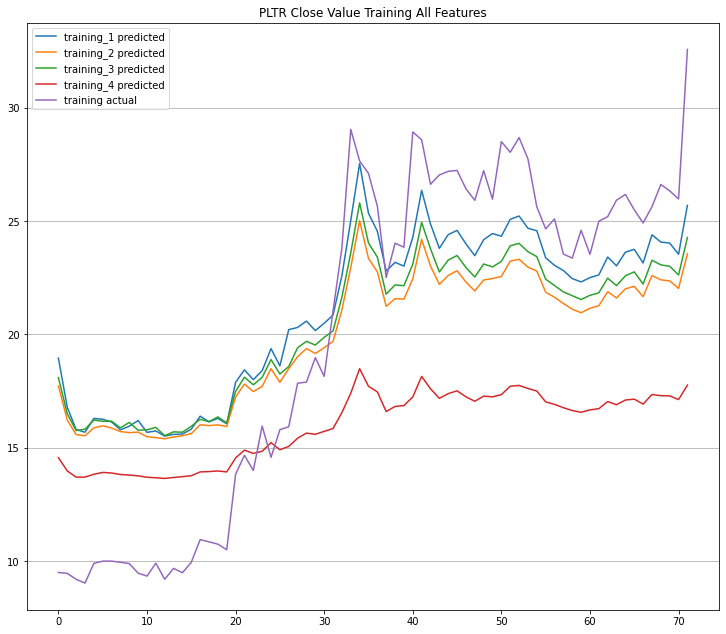

In [114]:
#Display Training Results
print('Root mean square error of is {}'.format(trainScore_1))
print('Root mean square error of is {}'.format(trainScore_2))
print('Root mean square error of is {}'.format(trainScore_3))
print('Root mean square error of is {}'.format(trainScore_4))

f = plt.figure()
f.set_figwidth(12.4)
f.set_figheight(10.8)
plt.plot(y_MinMax.inverse_transform(train_1),label='training_1 predicted')
plt.plot(y_MinMax.inverse_transform(train_2),label='training_2 predicted')
plt.plot(y_MinMax.inverse_transform(train_3),label='training_3 predicted')
plt.plot(y_MinMax.inverse_transform(train_4),label='training_4 predicted')
plt.plot(y_MinMax.inverse_transform(y_train),label='training actual')
plt.title('PLTR Close Value Training All Features')
plt.legend()
plt.grid(axis = 'y')
plt.show()
plt.clf()
plt.cla()
plt.close()


# BB

In [115]:
df_bb

,id,title,score,total_awards_received,created_utc,num_comments,Date,sentiment,confidence
38,ll0bi2,I have no idea what I'm talking about but aren...,1,0.0,1613467636,32,2021-02-16,1.0,0.806438
372,lkx8o2,AI generated DD for GME - says don't buy it - ...,1,0.0,1613454751,2,2021-02-16,-1.0,0.999875
385,lkx6iq,AI generated DD for GME - says don't buy it - ...,1,0.0,1613454542,2,2021-02-16,-1.0,0.999875
617,lkveq6,Total Return: -666.69 bby,1,0.0,1613448436,1,2021-02-16,-1.0,0.999290
689,lkuvrd,Investment bubble in hydrogen power stocks bui...,1,0.0,1613446680,0,2021-02-16,1.0,0.815080
...,...,...,...,...,...,...,...,...,...
1118189,1939y7,Short straddles on AAPL has been like robbing ...,13,NaN,1361646203,29,2013-02-23,-1.0,0.998509
1118276,14nx4y,It's not really a bubble when a biotech compan...,10,NaN,1355233667,7,2012-12-11,-1.0,0.983618
1118578,vpj00,I know it started as a joke but I could use a ...,17,NaN,1340835884,17,2012-06-27,-1.0,0.675808
1118776,tfnek,Just got inside info that I ruffles weathers a...,1,NaN,1336610775,0,2012-05-10,1.0,0.962597


In [116]:
df_bb_averages = get_daily_averages(df_bb)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [117]:
df_bb_stock = get_market_data('BB',df_bb_averages,'2012-06-19',drop_NaN=True)
df_bb_stock = df_bb_stock[['Close','Open','High','Low','Volume','Dividends','Stock Splits','score','num_comments','sentiment','confidence']]

In [118]:
dataset = df_bb_stock.values


# Scale and split train/test
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1)) 

tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    
#reshape the data to needed shape for lstm
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM model
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
79/79 [==============================] - 6s 8ms/step - loss: 0.0569
Epoch 2/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0420
Epoch 3/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0209
Epoch 4/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0068
Epoch 5/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0049
Epoch 6/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0047
Epoch 7/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0039
Epoch 8/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0033
Epoch 9/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0027
Epoch 10/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0022
Epoch 11/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0017
Epoch 12/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0013
Epoch 13/40
79/79 [==============================

In [119]:
#testing results
test_1 = model.predict(X_test_scale)
testScore_1 = np.sqrt(mean_squared_error(y_test[:], test_1[:,0]))

#training results
train_1 = model.predict(X_train_scale)
trainScore_1 = np.sqrt(mean_squared_error(y_train[:], train_1[:,0]))


# BB without text sentiment

In [120]:
# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-2])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
79/79 [==============================] - 6s 8ms/step - loss: 0.0596
Epoch 2/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0483
Epoch 3/40
79/79 [==============================] - 1s 7ms/step - loss: 0.0325
Epoch 4/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0152
Epoch 5/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0069
Epoch 6/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0058
Epoch 7/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0052
Epoch 8/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0046
Epoch 9/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0040
Epoch 10/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0034
Epoch 11/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0026
Epoch 12/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0021
Epoch 13/40
79/79 [==============================

In [121]:
#testing results
test_2 = model.predict(X_test_scale)
testScore_2 = np.sqrt(mean_squared_error(y_test[:], test_2[:,0]))

#training results
train_2 = model.predict(X_train_scale)
trainScore_2 = np.sqrt(mean_squared_error(y_train[:], train_2[:,0]))


# BB only sentiment

In [122]:
dataset = df_bb_stock[['Close','Open','High','Low','Volume','Dividends','Stock Splits','sentiment','confidence','score','num_comments']].values

In [123]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-2])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
79/79 [==============================] - 7s 8ms/step - loss: 0.0594
Epoch 2/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0480
Epoch 3/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0318
Epoch 4/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0138
Epoch 5/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0062
Epoch 6/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0055
Epoch 7/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0048
Epoch 8/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0043
Epoch 9/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0038
Epoch 10/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0032
Epoch 11/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0027
Epoch 12/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0022
Epoch 13/40
79/79 [==============================

In [124]:
#testing results
test_3 = model.predict(X_test_scale)
testScore_3 = np.sqrt(mean_squared_error(y_test[:], test_3[:,0]))

#training results
train_3 = model.predict(X_train_scale)
trainScore_3 = np.sqrt(mean_squared_error(y_train[:], train_3[:,0]))


# BB without wallstreetbets info

In [125]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-4])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
79/79 [==============================] - 6s 7ms/step - loss: 0.0594
Epoch 2/40
79/79 [==============================] - 1s 7ms/step - loss: 0.0498
Epoch 3/40
79/79 [==============================] - 1s 7ms/step - loss: 0.0365
Epoch 4/40
79/79 [==============================] - 1s 7ms/step - loss: 0.0205
Epoch 5/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0090
Epoch 6/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0061
Epoch 7/40
79/79 [==============================] - 1s 7ms/step - loss: 0.0058
Epoch 8/40
79/79 [==============================] - 1s 8ms/step - loss: 0.0051
Epoch 9/40
79/79 [==============================] - 1s 7ms/step - loss: 0.0044
Epoch 10/40
79/79 [==============================] - 1s 7ms/step - loss: 0.0041
Epoch 11/40
79/79 [==============================] - 1s 7ms/step - loss: 0.0035
Epoch 12/40
79/79 [==============================] - 1s 7ms/step - loss: 0.0031
Epoch 13/40
79/79 [==============================

In [126]:
#testing results
test_4 = model.predict(X_test_scale)
testScore_4 = np.sqrt(mean_squared_error(y_test[:], test_4[:,0]))

#training results
train_4 = model.predict(X_train_scale)
trainScore_4 = np.sqrt(mean_squared_error(y_train[:], train_4[:,0]))


Root mean square error with Only Stock info is 0.04545470077981924
Root mean square error with added WSB Features is 0.05314765449745759
Root mean square error with added Sentiment is 0.05236394095462995
Root mean square error with Both Features is 0.054808105221366234


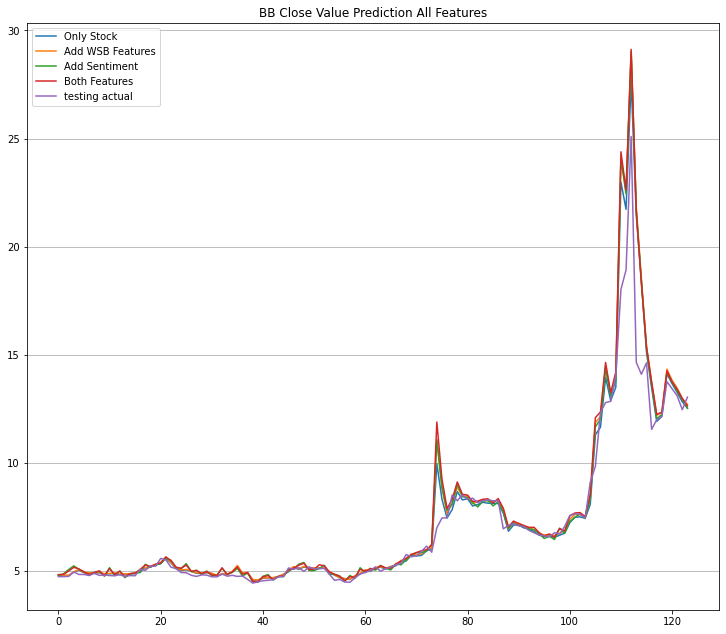

In [127]:
#display testing results
print('Root mean square error with Only Stock info is {}'.format(testScore_4))
print('Root mean square error with added WSB Features is {}'.format(testScore_2))
print('Root mean square error with added Sentiment is {}'.format(testScore_3))
print('Root mean square error with Both Features is {}'.format(testScore_1))

f = plt.figure()
f.set_figwidth(12.4)
f.set_figheight(10.8)
plt.plot(y_MinMax.inverse_transform(test_4),label='Only Stock')
plt.plot(y_MinMax.inverse_transform(test_2),label='Add WSB Features')
plt.plot(y_MinMax.inverse_transform(test_3),label='Add Sentiment')
plt.plot(y_MinMax.inverse_transform(test_1),label='Both Features')
plt.plot(y_MinMax.inverse_transform(y_test),label='testing actual')
plt.title('BB Close Value Prediction All Features')
plt.legend()
plt.grid(axis = 'y')
plt.show()
plt.clf()
plt.cla()
plt.close()


Root mean square error of is 0.018499847413474053
Root mean square error of is 0.015459433326029764
Root mean square error of is 0.015811361394079796
Root mean square error of is 0.011580870343685308


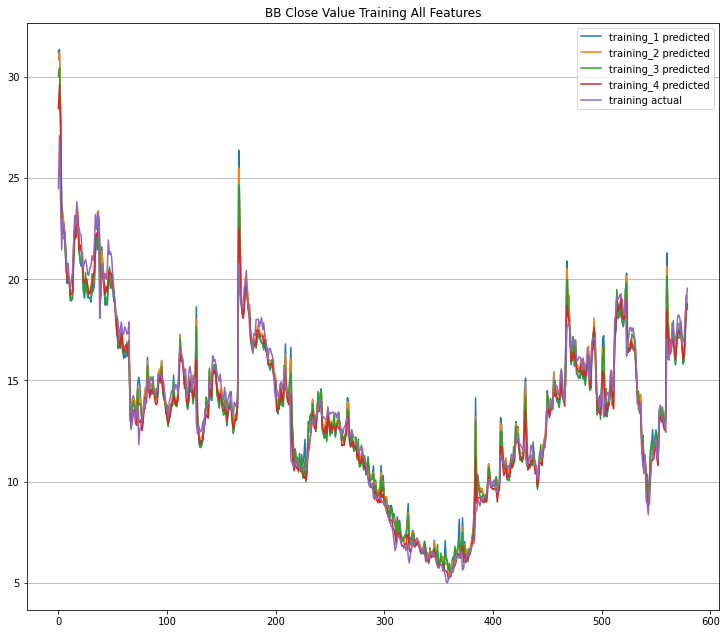

In [186]:
#Display Training Results
print('Root mean square error of is {}'.format(trainScore_1))
print('Root mean square error of is {}'.format(trainScore_2))
print('Root mean square error of is {}'.format(trainScore_3))
print('Root mean square error of is {}'.format(trainScore_4))

f = plt.figure()
f.set_figwidth(12.4)
f.set_figheight(10.8)
plt.plot(y_MinMax.inverse_transform(train_1),label='training_1 predicted')
plt.plot(y_MinMax.inverse_transform(train_2),label='training_2 predicted')
plt.plot(y_MinMax.inverse_transform(train_3),label='training_3 predicted')
plt.plot(y_MinMax.inverse_transform(train_4),label='training_4 predicted')
plt.plot(y_MinMax.inverse_transform(y_train),label='training actual')
plt.title('BB Close Value Training All Features')
plt.legend()
plt.grid(axis = 'y')
plt.show()
plt.clf()
plt.cla()
plt.close()


# MU

In [129]:
df_mu

,id,title,score,total_awards_received,created_utc,num_comments,Date,sentiment,confidence
54,ll064b,Micron is SERIOUSLY undervalued.. Buy now befo...,1,0.0,1613466899,0,2021-02-16,-1.0,0.998154
61,ll0597,MICRON STOCK IS SERIOUSLY UNDERVALUED !! THEY ...,1,0.0,1613466783,0,2021-02-16,-1.0,0.967806
1323,lkpzth,UNBELIEVEABLE - MUST READ,1,0.0,1613431221,2,2021-02-15,1.0,0.997887
1326,lkpyva,MUST READ DD!!! STOP DELETING,1,0.0,1613431138,2,2021-02-15,-1.0,0.904297
1896,lklctx,MUST READ!!! GME,1,0.0,1613418238,2,2021-02-15,1.0,0.995954
...,...,...,...,...,...,...,...,...,...
1117109,1x92vj,$TMUS (T-Mobile US Inc.) February 22 Calls,12,NaN,1391752273,6,2014-02-07,-1.0,0.998994
1117445,1tdqlg,$TMUS Made almost 300% on options from followi...,5,NaN,1387606207,10,2013-12-21,1.0,0.848791
1117559,1rjc7o,TMUS January 28 Strike Options,4,NaN,1385512984,2,2013-11-27,-1.0,0.979791
1117910,1i3a7w,Anyone else playing MU after the dip from $14?,0,NaN,1373562253,0,2013-07-11,-1.0,0.990546


In [130]:
df_mu_averages = get_daily_averages(df_mu)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [131]:
df_mu_stock = get_market_data('MU',df_mu_averages,'2013-06-06',drop_NaN=True)
df_mu_stock = df_mu_stock[['Close','Open','High','Low','Volume','Dividends','Stock Splits','score','num_comments','sentiment','confidence']]

In [132]:
dataset = df_mu_stock.values

# Scale and split train/test
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1)) 

tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    
#reshape the data to needed shape for lstm
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM model
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
85/85 [==============================] - 6s 8ms/step - loss: 0.1581
Epoch 2/40
85/85 [==============================] - 1s 8ms/step - loss: 0.1193
Epoch 3/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0582
Epoch 4/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0119
Epoch 5/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0080
Epoch 6/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0066
Epoch 7/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0066
Epoch 8/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0057
Epoch 9/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0053
Epoch 10/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0046
Epoch 11/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0044
Epoch 12/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0037
Epoch 13/40
85/85 [==============================

In [133]:
#testing results
test_1 = model.predict(X_test_scale)
testScore_1 = np.sqrt(mean_squared_error(y_test[:], test_1[:,0]))

#training results
train_1 = model.predict(X_train_scale)
trainScore_1 = np.sqrt(mean_squared_error(y_train[:], train_1[:,0]))


# MU without text sentiment

In [134]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-2])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
85/85 [==============================] - 6s 8ms/step - loss: 0.1653
Epoch 2/40
85/85 [==============================] - 1s 8ms/step - loss: 0.1365
Epoch 3/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0887
Epoch 4/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0302
Epoch 5/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0086
Epoch 6/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0076
Epoch 7/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0067
Epoch 8/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0065
Epoch 9/40
85/85 [==============================] - 1s 7ms/step - loss: 0.0057
Epoch 10/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0050
Epoch 11/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0046
Epoch 12/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0042
Epoch 13/40
85/85 [==============================

In [135]:
#testing results
test_2 = model.predict(X_test_scale)
testScore_2 = np.sqrt(mean_squared_error(y_test[:], test_2[:,0]))

#training results
train_2 = model.predict(X_train_scale)
trainScore_2 = np.sqrt(mean_squared_error(y_train[:], train_2[:,0]))


# MU only sentiment

In [136]:
dataset = df_mu_stock[['Close','Open','High','Low','Volume','Dividends','Stock Splits','sentiment','confidence','score','num_comments']].values

In [137]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-2])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
85/85 [==============================] - 6s 8ms/step - loss: 0.1641
Epoch 2/40
85/85 [==============================] - 1s 7ms/step - loss: 0.1376
Epoch 3/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0933
Epoch 4/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0353
Epoch 5/40
85/85 [==============================] - 1s 7ms/step - loss: 0.0098
Epoch 6/40
85/85 [==============================] - 1s 7ms/step - loss: 0.0082
Epoch 7/40
85/85 [==============================] - 1s 7ms/step - loss: 0.0077
Epoch 8/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0070
Epoch 9/40
85/85 [==============================] - 1s 7ms/step - loss: 0.0067
Epoch 10/40
85/85 [==============================] - 1s 7ms/step - loss: 0.0060
Epoch 11/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0053
Epoch 12/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0046
Epoch 13/40
85/85 [==============================

In [138]:
#testing results
test_3 = model.predict(X_test_scale)
testScore_3 = np.sqrt(mean_squared_error(y_test[:], test_3[:,0]))

#training results
train_3 = model.predict(X_train_scale)
trainScore_3 = np.sqrt(mean_squared_error(y_train[:], train_3[:,0]))


# MU without wallstreetbets info

In [139]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-4])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
85/85 [==============================] - 6s 7ms/step - loss: 0.1646
Epoch 2/40
85/85 [==============================] - 1s 7ms/step - loss: 0.1428
Epoch 3/40
85/85 [==============================] - 1s 8ms/step - loss: 0.1093
Epoch 4/40
85/85 [==============================] - 1s 7ms/step - loss: 0.0618
Epoch 5/40
85/85 [==============================] - 1s 7ms/step - loss: 0.0201
Epoch 6/40
85/85 [==============================] - 1s 7ms/step - loss: 0.0087
Epoch 7/40
85/85 [==============================] - 1s 7ms/step - loss: 0.0082
Epoch 8/40
85/85 [==============================] - 1s 7ms/step - loss: 0.0076
Epoch 9/40
85/85 [==============================] - 1s 7ms/step - loss: 0.0070
Epoch 10/40
85/85 [==============================] - 1s 7ms/step - loss: 0.0065
Epoch 11/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0058
Epoch 12/40
85/85 [==============================] - 1s 7ms/step - loss: 0.0053
Epoch 13/40
85/85 [==============================

In [140]:
#testing results
test_4 = model.predict(X_test_scale)
testScore_4 = np.sqrt(mean_squared_error(y_test[:], test_4[:,0]))

#training results
train_4 = model.predict(X_train_scale)
trainScore_4 = np.sqrt(mean_squared_error(y_train[:], train_4[:,0]))


Root mean square error with Only Stock info is 0.03313661611095985
Root mean square error with added WSB Features is 0.029658424418856282
Root mean square error with added Sentiment is 0.028191230160340607
Root mean square error with Both Features is 0.035348686861026234


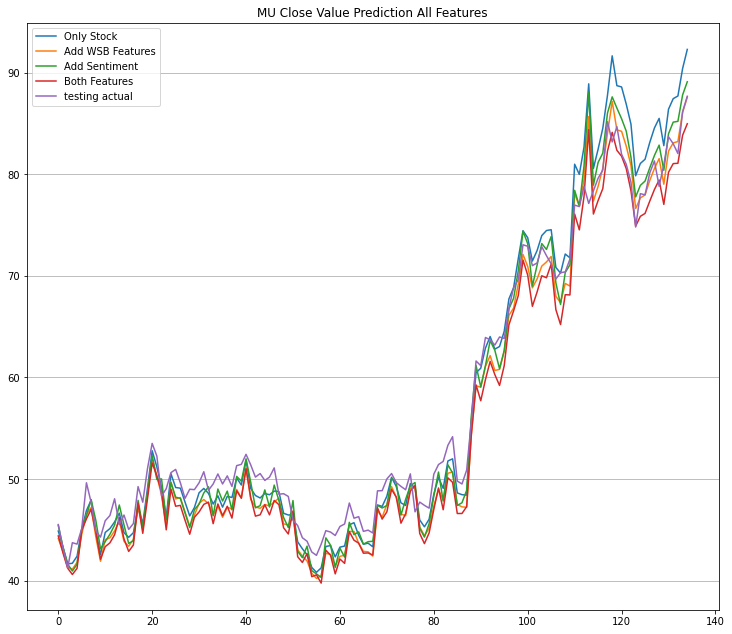

In [141]:
#display testing results
print('Root mean square error with Only Stock info is {}'.format(testScore_4))
print('Root mean square error with added WSB Features is {}'.format(testScore_2))
print('Root mean square error with added Sentiment is {}'.format(testScore_3))
print('Root mean square error with Both Features is {}'.format(testScore_1))

f = plt.figure()
f.set_figwidth(12.4)
f.set_figheight(10.8)
plt.plot(y_MinMax.inverse_transform(test_4),label='Only Stock')
plt.plot(y_MinMax.inverse_transform(test_2),label='Add WSB Features')
plt.plot(y_MinMax.inverse_transform(test_3),label='Add Sentiment')
plt.plot(y_MinMax.inverse_transform(test_1),label='Both Features')
plt.plot(y_MinMax.inverse_transform(y_test),label='testing actual')
plt.title('MU Close Value Prediction All Features')
plt.legend()
plt.grid(axis = 'y')
plt.show()
plt.clf()
plt.cla()
plt.close()


Root mean square error of is 0.029109000728069132
Root mean square error of is 0.025932999572744652
Root mean square error of is 0.026199458948437032
Root mean square error of is 0.021623263876982417


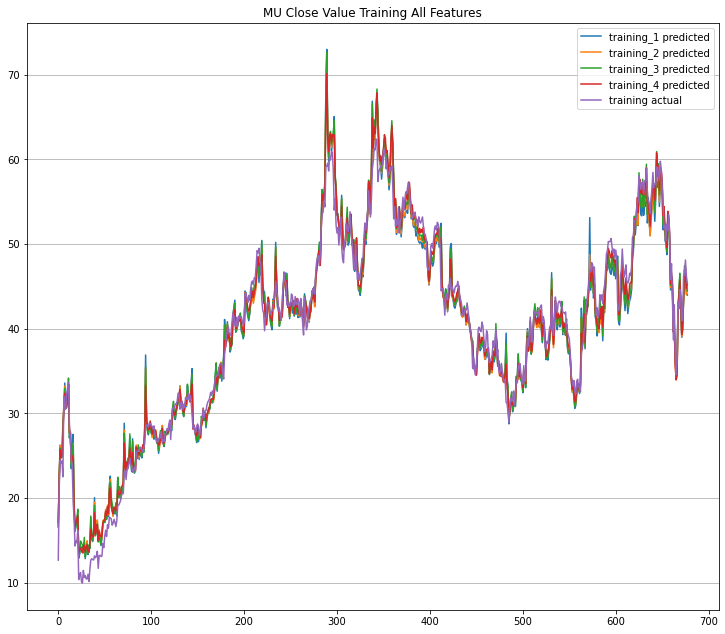

In [142]:
#Display Training Results
print('Root mean square error of is {}'.format(trainScore_1))
print('Root mean square error of is {}'.format(trainScore_2))
print('Root mean square error of is {}'.format(trainScore_3))
print('Root mean square error of is {}'.format(trainScore_4))

f = plt.figure()
f.set_figwidth(12.4)
f.set_figheight(10.8)
plt.plot(y_MinMax.inverse_transform(train_1),label='training_1 predicted')
plt.plot(y_MinMax.inverse_transform(train_2),label='training_2 predicted')
plt.plot(y_MinMax.inverse_transform(train_3),label='training_3 predicted')
plt.plot(y_MinMax.inverse_transform(train_4),label='training_4 predicted')
plt.plot(y_MinMax.inverse_transform(y_train),label='training actual')
plt.title('MU Close Value Training All Features')
plt.legend()
plt.grid(axis = 'y')
plt.show()
plt.clf()
plt.cla()
plt.close()


# Apple

In [143]:
df_apple

,id,title,score,total_awards_received,created_utc,num_comments,Date,sentiment,confidence
81,lkzz8c,What's the future ? Will they ever coop large ...,1,0.0,1613466112,0,2021-02-16,-1.0,0.501999
522,lkw2er,Apple car,1,0.0,1613450672,1,2021-02-16,1.0,0.995122
542,lkvwy5,Apple iCar,1,0.0,1613450129,1,2021-02-16,1.0,0.743485
1087,lks1f8,Looking to start buying is Robinhood still rel...,1,0.0,1613437534,2,2021-02-16,1.0,0.840523
1378,lkpilg,Have 68K in $QUBT. Hoping it will be uplisted ...,1,0.0,1613429832,0,2021-02-15,-1.0,0.989291
...,...,...,...,...,...,...,...,...,...
1117670,1p2p58,[Discussion] Possible Long Term Strategy - Put...,5,NaN,1382559983,16,2013-10-23,1.0,0.964463
1117779,1lt88k,Apple 5c YES = stock run-up. If NO Apple 5c = ...,5,NaN,1378417168,16,2013-09-05,-1.0,0.999889
1117798,1l7idp,"Nasa loves them, Omega watches use them, now A...",1,NaN,1377632527,6,2013-08-27,1.0,0.995658
1118405,ys9mw,Apple WINS lawsuit against Samsung,4,NaN,1345856589,5,2012-08-25,-1.0,0.984909


In [144]:
df_apple_averages = get_daily_averages(df_apple)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [145]:
df_apple_stock = get_market_data('AAPL',df_apple_averages,'2012-08-07',drop_NaN=True)
df_apple_stock = df_apple_stock[['Close','Open','High','Low','Volume','Dividends','Stock Splits','score','num_comments','sentiment','confidence']]

In [146]:

# Scale and split train/test
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1)) 

tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    
#reshape the data to needed shape for lstm
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM model
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
85/85 [==============================] - 8s 8ms/step - loss: 0.1570
Epoch 2/40
85/85 [==============================] - 1s 8ms/step - loss: 0.1158
Epoch 3/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0538
Epoch 4/40
85/85 [==============================] - 1s 7ms/step - loss: 0.0119
Epoch 5/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0085
Epoch 6/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0078
Epoch 7/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0072
Epoch 8/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0068
Epoch 9/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0063
Epoch 10/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0056
Epoch 11/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0051
Epoch 12/40
85/85 [==============================] - 1s 7ms/step - loss: 0.0046
Epoch 13/40
85/85 [==============================

In [147]:
#testing results
test_1 = model.predict(X_test_scale)
testScore_1 = np.sqrt(mean_squared_error(y_test[:], test_1[:,0]))

#training results
train_1 = model.predict(X_train_scale)
trainScore_1 = np.sqrt(mean_squared_error(y_train[:], train_1[:,0]))


# Apple without text sentiment

In [148]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-2])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
85/85 [==============================] - 6s 8ms/step - loss: 0.1651
Epoch 2/40
85/85 [==============================] - 1s 8ms/step - loss: 0.1388
Epoch 3/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0953
Epoch 4/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0366
Epoch 5/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0096
Epoch 6/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0079
Epoch 7/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0076
Epoch 8/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0066
Epoch 9/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0061
Epoch 10/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0055
Epoch 11/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0050
Epoch 12/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0046
Epoch 13/40
85/85 [==============================

In [149]:
#testing results
test_2 = model.predict(X_test_scale)
testScore_2 = np.sqrt(mean_squared_error(y_test[:], test_2[:,0]))

#training results
train_2 = model.predict(X_train_scale)
trainScore_2 = np.sqrt(mean_squared_error(y_train[:], train_2[:,0]))


# Apple only sentiment

In [150]:
dataset = df_apple_stock[['Close','Open','High','Low','Volume','Dividends','Stock Splits','sentiment','confidence','score','num_comments']].values


In [151]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-2])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
93/93 [==============================] - 6s 8ms/step - loss: 0.0691
Epoch 2/40
93/93 [==============================] - 1s 7ms/step - loss: 0.0530
Epoch 3/40
93/93 [==============================] - 1s 8ms/step - loss: 0.0299
Epoch 4/40
93/93 [==============================] - 1s 7ms/step - loss: 0.0123
Epoch 5/40
93/93 [==============================] - 1s 8ms/step - loss: 0.0092
Epoch 6/40
93/93 [==============================] - 1s 8ms/step - loss: 0.0081
Epoch 7/40
93/93 [==============================] - 1s 8ms/step - loss: 0.0073
Epoch 8/40
93/93 [==============================] - 1s 7ms/step - loss: 0.0063
Epoch 9/40
93/93 [==============================] - 1s 8ms/step - loss: 0.0052
Epoch 10/40
93/93 [==============================] - 1s 8ms/step - loss: 0.0044
Epoch 11/40
93/93 [==============================] - 1s 8ms/step - loss: 0.0033
Epoch 12/40
93/93 [==============================] - 1s 8ms/step - loss: 0.0025
Epoch 13/40
93/93 [==============================

In [152]:
#testing results
test_3 = model.predict(X_test_scale)
testScore_3 = np.sqrt(mean_squared_error(y_test[:], test_3[:,0]))

#training results
train_3 = model.predict(X_train_scale)
trainScore_3 = np.sqrt(mean_squared_error(y_train[:], train_3[:,0]))


# Apple without wallstreetbets info

In [153]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-4])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
93/93 [==============================] - 6s 8ms/step - loss: 0.0698
Epoch 2/40
93/93 [==============================] - 1s 8ms/step - loss: 0.0574
Epoch 3/40
93/93 [==============================] - 1s 7ms/step - loss: 0.0397
Epoch 4/40
93/93 [==============================] - 1s 8ms/step - loss: 0.0198
Epoch 5/40
93/93 [==============================] - 1s 8ms/step - loss: 0.0100
Epoch 6/40
93/93 [==============================] - 1s 7ms/step - loss: 0.0086
Epoch 7/40
93/93 [==============================] - 1s 7ms/step - loss: 0.0079
Epoch 8/40
93/93 [==============================] - 1s 7ms/step - loss: 0.0070
Epoch 9/40
93/93 [==============================] - 1s 7ms/step - loss: 0.0060
Epoch 10/40
93/93 [==============================] - 1s 7ms/step - loss: 0.0051
Epoch 11/40
93/93 [==============================] - 1s 7ms/step - loss: 0.0041
Epoch 12/40
93/93 [==============================] - 1s 8ms/step - loss: 0.0032
Epoch 13/40
93/93 [==============================

In [154]:
#testing results
test_4 = model.predict(X_test_scale)
testScore_4 = np.sqrt(mean_squared_error(y_test[:], test_4[:,0]))

#training results
train_4 = model.predict(X_train_scale)
trainScore_4 = np.sqrt(mean_squared_error(y_train[:], train_4[:,0]))


Root mean square error with Only Stock info is 0.07641389834763113
Root mean square error with added WSB Features is 0.0358588548042939
Root mean square error with added Sentiment is 0.052845671474267455
Root mean square error with Both Features is 0.03274462808202631


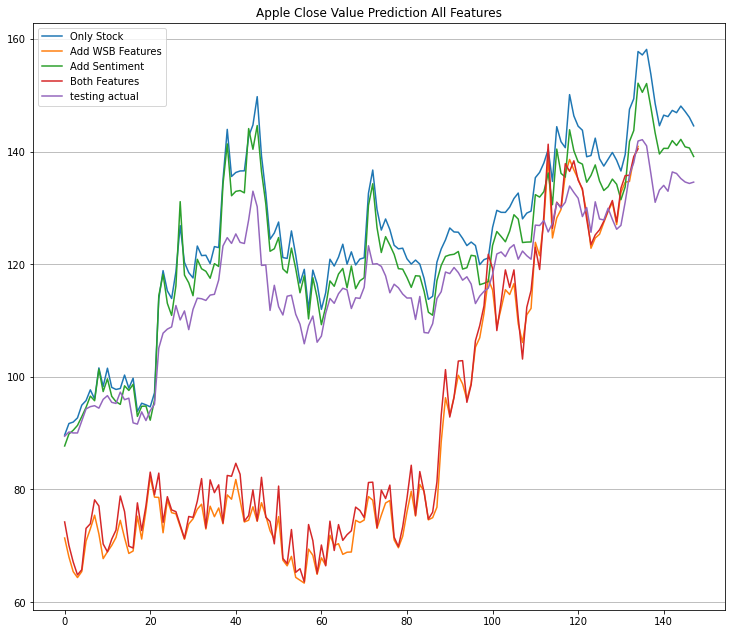

In [155]:
#display testing results
print('Root mean square error with Only Stock info is {}'.format(testScore_4))
print('Root mean square error with added WSB Features is {}'.format(testScore_2))
print('Root mean square error with added Sentiment is {}'.format(testScore_3))
print('Root mean square error with Both Features is {}'.format(testScore_1))

f = plt.figure()
f.set_figwidth(12.4)
f.set_figheight(10.8)
plt.plot(y_MinMax.inverse_transform(test_4),label='Only Stock')
plt.plot(y_MinMax.inverse_transform(test_2),label='Add WSB Features')
plt.plot(y_MinMax.inverse_transform(test_3),label='Add Sentiment')
plt.plot(y_MinMax.inverse_transform(test_1),label='Both Features')
plt.plot(y_MinMax.inverse_transform(y_test),label='testing actual')
plt.title('Apple Close Value Prediction All Features')
plt.legend()
plt.grid(axis = 'y')
plt.show()
plt.clf()
plt.cla()
plt.close()


Root mean square error of is 0.032143613528830266
Root mean square error of is 0.02854549435624221
Root mean square error of is 0.025344973424737162
Root mean square error of is 0.017657815240461703


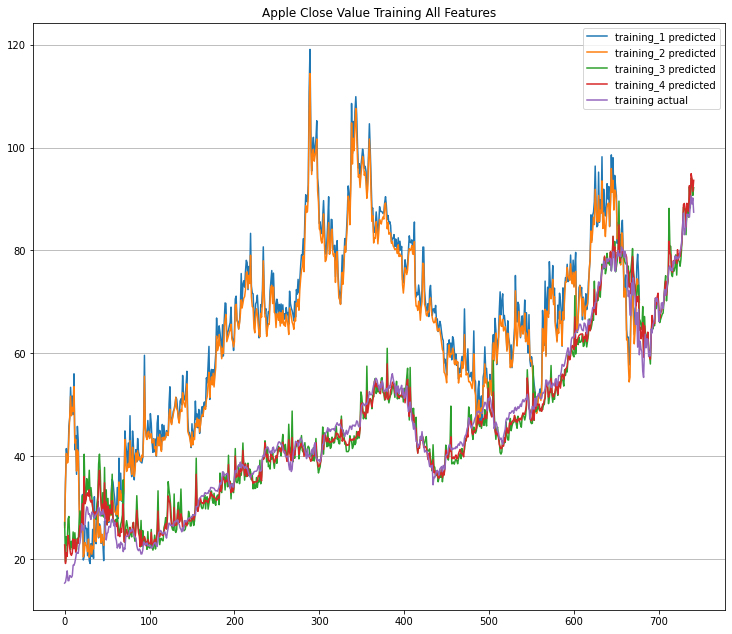

In [156]:
#Display Training Results
print('Root mean square error of is {}'.format(trainScore_1))
print('Root mean square error of is {}'.format(trainScore_2))
print('Root mean square error of is {}'.format(trainScore_3))
print('Root mean square error of is {}'.format(trainScore_4))

f = plt.figure()
f.set_figwidth(12.4)
f.set_figheight(10.8)
plt.plot(y_MinMax.inverse_transform(train_1),label='training_1 predicted')
plt.plot(y_MinMax.inverse_transform(train_2),label='training_2 predicted')
plt.plot(y_MinMax.inverse_transform(train_3),label='training_3 predicted')
plt.plot(y_MinMax.inverse_transform(train_4),label='training_4 predicted')
plt.plot(y_MinMax.inverse_transform(y_train),label='training actual')
plt.title('Apple Close Value Training All Features')
plt.legend()
plt.grid(axis = 'y')
plt.show()
plt.clf()
plt.cla()
plt.close()


# Amazon

In [157]:
df_amazon

,id,title,score,total_awards_received,created_utc,num_comments,Date,sentiment,confidence
483,lkwb3q,"Find Out Why $Mnfsf is Considered to be ""The A...",1,0.0,1613451499,2,2021-02-16,-1.0,0.962371
698,lkutji,Forbs Retweets on 2/15 Amazon buying AMC,1,0.0,1613446527,0,2021-02-16,-1.0,0.998201
866,lktjp7,Amazon buyin amc?,1,0.0,1613442468,1,2021-02-16,-1.0,0.838020
890,lktddr,Amazon Buying AMC???,1,0.0,1613441884,0,2021-02-16,-1.0,0.997139
900,lktaek,Amazon buyout #amc,1,0.0,1613441608,1,2021-02-16,1.0,0.780284
...,...,...,...,...,...,...,...,...,...
1118216,17gu2t,AMZN earnings 1/29. Ideas?,12,NaN,1359423401,8,2013-01-29,-1.0,0.999510
1118262,15fc9y,A question about Netflix and Amazon come Wedne...,0,NaN,1356455353,3,2012-12-25,-1.0,0.993682
1118324,12pgx4,Free Kindle book on Amazon: Systematic and Aut...,20,NaN,1352170586,3,2012-11-06,1.0,0.964612
1118491,x5eh0,Thursday 7/26 Earnings After The Bell [AMZN] [...,7,NaN,1343247736,21,2012-07-25,-1.0,0.992635


In [158]:
df_amazon_averages = get_daily_averages(df_amazon)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [159]:
df_amazon_stock = get_market_data('AMZN',df_amazon_averages,'2012-04-26',drop_NaN=True)
df_amazon_stock = df_amazon_stock[['Close','Open','High','Low','Volume','Dividends','Stock Splits','score','num_comments','sentiment','confidence']]


In [160]:
dataset = df_amazon_stock.values

# Scale and split train/test
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1)) 

tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    
#reshape the data to needed shape for lstm
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM model
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
98/98 [==============================] - 6s 8ms/step - loss: 0.1518
Epoch 2/40
98/98 [==============================] - 1s 8ms/step - loss: 0.1067
Epoch 3/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0374
Epoch 4/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0090
Epoch 5/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0083
Epoch 6/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0073
Epoch 7/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0064
Epoch 8/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0057
Epoch 9/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0048
Epoch 10/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0041
Epoch 11/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0034
Epoch 12/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0029
Epoch 13/40
98/98 [==============================

In [161]:
#testing results
test_1 = model.predict(X_test_scale)
testScore_1 = np.sqrt(mean_squared_error(y_test[:], test_1[:,0]))

#training results
train_1 = model.predict(X_train_scale)
trainScore_1 = np.sqrt(mean_squared_error(y_train[:], train_1[:,0]))


# Amazon without text sentiment

In [162]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-2])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
98/98 [==============================] - 6s 8ms/step - loss: 0.1559
Epoch 2/40
98/98 [==============================] - 1s 8ms/step - loss: 0.1201
Epoch 3/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0635
Epoch 4/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0156
Epoch 5/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0090
Epoch 6/40
98/98 [==============================] - 1s 7ms/step - loss: 0.0082
Epoch 7/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0072
Epoch 8/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0063
Epoch 9/40
98/98 [==============================] - 1s 7ms/step - loss: 0.0055
Epoch 10/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0047
Epoch 11/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0039
Epoch 12/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0035
Epoch 13/40
98/98 [==============================

In [163]:
#testing results
test_2 = model.predict(X_test_scale)
testScore_2 = np.sqrt(mean_squared_error(y_test[:], test_2[:,0]))

#training results
train_2 = model.predict(X_train_scale)
trainScore_2 = np.sqrt(mean_squared_error(y_train[:], train_2[:,0]))


# Amazon only sentiment

In [164]:
dataset = df_amazon_stock[['Close','Open','High','Low','Volume','Dividends','Stock Splits','sentiment','confidence','score','num_comments']].values


In [165]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-2])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
98/98 [==============================] - 6s 7ms/step - loss: 0.1569
Epoch 2/40
98/98 [==============================] - 1s 8ms/step - loss: 0.1232
Epoch 3/40
98/98 [==============================] - 1s 7ms/step - loss: 0.0655
Epoch 4/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0160
Epoch 5/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0097
Epoch 6/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0086
Epoch 7/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0074
Epoch 8/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0069
Epoch 9/40
98/98 [==============================] - 1s 7ms/step - loss: 0.0062
Epoch 10/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0052
Epoch 11/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0043
Epoch 12/40
98/98 [==============================] - 1s 8ms/step - loss: 0.0036
Epoch 13/40
98/98 [==============================

In [166]:
#testing results
test_3 = model.predict(X_test_scale)
testScore_3 = np.sqrt(mean_squared_error(y_test[:], test_3[:,0]))

#training results
train_3 = model.predict(X_train_scale)
trainScore_3 = np.sqrt(mean_squared_error(y_train[:], train_3[:,0]))


# Amazon without wallstreetbets info

In [167]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-4])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
98/98 [==============================] - 6s 7ms/step - loss: 0.1601
Epoch 2/40
98/98 [==============================] - 1s 7ms/step - loss: 0.1368
Epoch 3/40
98/98 [==============================] - 1s 7ms/step - loss: 0.0984
Epoch 4/40
98/98 [==============================] - 1s 7ms/step - loss: 0.0450
Epoch 5/40
98/98 [==============================] - 1s 7ms/step - loss: 0.0135
Epoch 6/40
98/98 [==============================] - 1s 7ms/step - loss: 0.0103
Epoch 7/40
98/98 [==============================] - 1s 7ms/step - loss: 0.0090
Epoch 8/40
98/98 [==============================] - 1s 7ms/step - loss: 0.0082
Epoch 9/40
98/98 [==============================] - 1s 7ms/step - loss: 0.0071
Epoch 10/40
98/98 [==============================] - 1s 7ms/step - loss: 0.0065
Epoch 11/40
98/98 [==============================] - 1s 7ms/step - loss: 0.0053
Epoch 12/40
98/98 [==============================] - 1s 7ms/step - loss: 0.0046
Epoch 13/40
98/98 [==============================

In [168]:
#testing results
test_4 = model.predict(X_test_scale)
testScore_4 = np.sqrt(mean_squared_error(y_test[:], test_4[:,0]))

#training results
train_4 = model.predict(X_train_scale)
trainScore_4 = np.sqrt(mean_squared_error(y_train[:], train_4[:,0]))


Root mean square error with Only Stock info is 0.08208709297602393
Root mean square error with added WSB Features is 0.0698716243785842
Root mean square error with added Sentiment is 0.06741978740673368
Root mean square error with Both Features is 0.0442555109524462


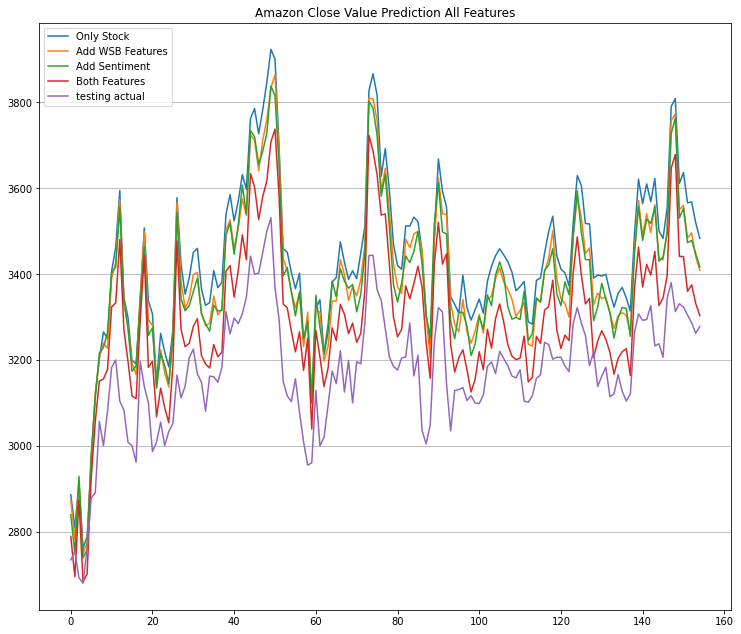

In [169]:
#display testing results
print('Root mean square error with Only Stock info is {}'.format(testScore_4))
print('Root mean square error with added WSB Features is {}'.format(testScore_2))
print('Root mean square error with added Sentiment is {}'.format(testScore_3))
print('Root mean square error with Both Features is {}'.format(testScore_1))

f = plt.figure()
f.set_figwidth(12.4)
f.set_figheight(10.8)
plt.plot(y_MinMax.inverse_transform(test_4),label='Only Stock')
plt.plot(y_MinMax.inverse_transform(test_2),label='Add WSB Features')
plt.plot(y_MinMax.inverse_transform(test_3),label='Add Sentiment')
plt.plot(y_MinMax.inverse_transform(test_1),label='Both Features')
plt.plot(y_MinMax.inverse_transform(y_test),label='testing actual')
plt.title('Amazon Close Value Prediction All Features')
plt.legend()
plt.grid(axis = 'y')
plt.show()
plt.clf()
plt.cla()
plt.close()


Root mean square error with Only Stock info is 0.08208709297602393
Root mean square error with added WSB Features is 0.0698716243785842
Root mean square error with added Sentiment is 0.06741978740673368
Root mean square error with Both Features is 0.0442555109524462


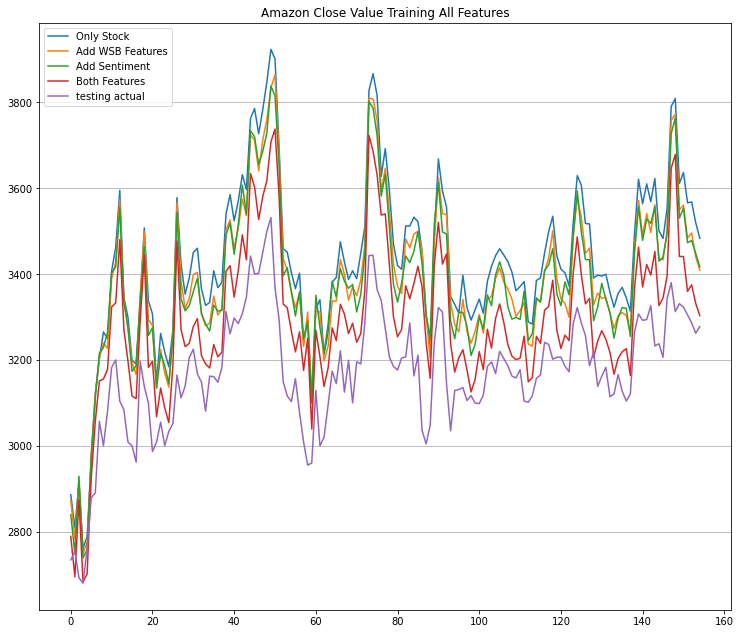

In [170]:
#display testing results
print('Root mean square error with Only Stock info is {}'.format(testScore_4))
print('Root mean square error with added WSB Features is {}'.format(testScore_2))
print('Root mean square error with added Sentiment is {}'.format(testScore_3))
print('Root mean square error with Both Features is {}'.format(testScore_1))

f = plt.figure()
f.set_figwidth(12.4)
f.set_figheight(10.8)
plt.plot(y_MinMax.inverse_transform(test_4),label='Only Stock')
plt.plot(y_MinMax.inverse_transform(test_2),label='Add WSB Features')
plt.plot(y_MinMax.inverse_transform(test_3),label='Add Sentiment')
plt.plot(y_MinMax.inverse_transform(test_1),label='Both Features')
plt.plot(y_MinMax.inverse_transform(y_test),label='testing actual')
plt.title('Amazon Close Value Training All Features')
plt.legend()
plt.grid(axis = 'y')
plt.show()
plt.clf()
plt.cla()
plt.close()


# SnapChat

In [171]:
df_snap

,id,title,score,total_awards_received,created_utc,num_comments,Date,sentiment,confidence
1280,lkqc5s,"Let’s buy Snapchat, The ads are whack🤷🏼‍♂️",1,0.0,1613432208,2,2021-02-15,-1.0,0.999933
1356,lkppbp,Chamath finna snap hedge funds out of existence 😎,1,0.0,1613430360,0,2021-02-15,-1.0,0.999814
5159,ljun3r,Cashapp $digmyvibe sucking a wall street guy b...,1,0.0,1613328898,2,2021-02-14,-1.0,0.993348
5167,ljulec,Where is the money at ? Cashapp $digmyvibe sna...,1,0.0,1613328763,0,2021-02-14,-1.0,0.997851
6889,ljgd7l,Get alot of shills in your inboxes? I used to ...,1,0.0,1613273525,2,2021-02-14,-1.0,0.999987
...,...,...,...,...,...,...,...,...,...
1100034,4gv6zj,Any news on the snapchat IPO?,6,NaN,1461866071,7,2016-04-28,-1.0,0.997373
1100206,4gosgr,Found a movie about one of you fags snapping a...,22,NaN,1461768342,9,2016-04-27,-1.0,0.998955
1105133,48ylrn,Saw a lot of you on Snapchat today,0,NaN,1457116461,0,2016-03-04,1.0,0.995571
1110509,3sd0qv,Fidelity marks down value of Snapchat 25%. Is ...,18,NaN,1447210968,33,2015-11-11,1.0,0.859120


In [172]:
df_snap_averages = get_daily_averages(df_snap)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [173]:
df_snap_stock = get_market_data('SNAP',df_snap_averages,'2015-11-04',drop_NaN=True)
df_snap_stock = df_snap_stock[['Close','Open','High','Low','Volume','Dividends','Stock Splits','score','num_comments','sentiment','confidence']]


In [174]:
dataset = df_snap_stock.values

# Scale and split train/test
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1)) 

tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    
#reshape the data to needed shape for lstm
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM model
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
73/73 [==============================] - 8s 8ms/step - loss: 0.0236
Epoch 2/40
73/73 [==============================] - 1s 7ms/step - loss: 0.0164
Epoch 3/40
73/73 [==============================] - 1s 7ms/step - loss: 0.0085
Epoch 4/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0041
Epoch 5/40
73/73 [==============================] - 1s 7ms/step - loss: 0.0036
Epoch 6/40
73/73 [==============================] - 1s 7ms/step - loss: 0.0033
Epoch 7/40
73/73 [==============================] - 1s 7ms/step - loss: 0.0032
Epoch 8/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0028
Epoch 9/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0025
Epoch 10/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0022
Epoch 11/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0018
Epoch 12/40
73/73 [==============================] - 1s 7ms/step - loss: 0.0014
Epoch 13/40
73/73 [==============================

In [175]:
#testing results
test_1 = model.predict(X_test_scale)
testScore_1 = np.sqrt(mean_squared_error(y_test[:], test_1[:,0]))

#training results
train_1 = model.predict(X_train_scale)
trainScore_1 = np.sqrt(mean_squared_error(y_train[:], train_1[:,0]))


# SnapChat without text sentiment

In [176]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-2])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
73/73 [==============================] - 5s 8ms/step - loss: 0.0232
Epoch 2/40
73/73 [==============================] - 1s 7ms/step - loss: 0.0166
Epoch 3/40
73/73 [==============================] - 1s 7ms/step - loss: 0.0093
Epoch 4/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0046
Epoch 5/40
73/73 [==============================] - 1s 7ms/step - loss: 0.0035
Epoch 6/40
73/73 [==============================] - 1s 7ms/step - loss: 0.0034
Epoch 7/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0032
Epoch 8/40
73/73 [==============================] - 1s 7ms/step - loss: 0.0029
Epoch 9/40
73/73 [==============================] - 1s 7ms/step - loss: 0.0025
Epoch 10/40
73/73 [==============================] - 1s 7ms/step - loss: 0.0023
Epoch 11/40
73/73 [==============================] - 1s 7ms/step - loss: 0.0020
Epoch 12/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0016
Epoch 13/40
73/73 [==============================

In [177]:
#testing results
test_2 = model.predict(X_test_scale)
testScore_2 = np.sqrt(mean_squared_error(y_test[:], test_2[:,0]))

#training results
train_2 = model.predict(X_train_scale)
trainScore_2 = np.sqrt(mean_squared_error(y_train[:], train_2[:,0]))


# SnapChat only sentiment

In [178]:
dataset = df_snap_stock[['Close','Open','High','Low','Volume','Dividends','Stock Splits','sentiment','confidence','score','num_comments']].values

In [179]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-2])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
73/73 [==============================] - 6s 8ms/step - loss: 0.0239
Epoch 2/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0180
Epoch 3/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0110
Epoch 4/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0056
Epoch 5/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0039
Epoch 6/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0036
Epoch 7/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0033
Epoch 8/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0032
Epoch 9/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0029
Epoch 10/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0027
Epoch 11/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0024
Epoch 12/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0021
Epoch 13/40
73/73 [==============================

In [180]:
#testing results
test_3 = model.predict(X_test_scale)
testScore_3 = np.sqrt(mean_squared_error(y_test[:], test_3[:,0]))

#training results
train_3 = model.predict(X_train_scale)
trainScore_3 = np.sqrt(mean_squared_error(y_train[:], train_3[:,0]))


# SnapChat without wallstreetbets info

In [181]:

# Scale and split train/test
X_MinMax = MinMaxScaler()
y_MinMax = MinMaxScaler()
X = X_MinMax.fit_transform(dataset[:, 1:-4])
y = y_MinMax.fit_transform(dataset[:, 0].reshape(-1, 1))

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM 
model = Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

model.fit(X_train_scale, y_train, epochs = 40, batch_size = 8)

Epoch 1/40
73/73 [==============================] - 6s 7ms/step - loss: 0.0244
Epoch 2/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0196
Epoch 3/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0140
Epoch 4/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0083
Epoch 5/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0049
Epoch 6/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0040
Epoch 7/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0038
Epoch 8/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0035
Epoch 9/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0033
Epoch 10/40
73/73 [==============================] - 1s 7ms/step - loss: 0.0032
Epoch 11/40
73/73 [==============================] - 1s 8ms/step - loss: 0.0029
Epoch 12/40
73/73 [==============================] - 1s 7ms/step - loss: 0.0027
Epoch 13/40
73/73 [==============================

In [182]:
#testing results
test_4 = model.predict(X_test_scale)
testScore_4 = np.sqrt(mean_squared_error(y_test[:], test_4[:,0]))

#training results
train_4 = model.predict(X_train_scale)
trainScore_4 = np.sqrt(mean_squared_error(y_train[:], train_4[:,0]))


Root mean square error with Only Stock info is 0.029783946853260114
Root mean square error with added WSB Features is 0.02456445902044778
Root mean square error with added Sentiment is 0.02637730240824587
Root mean square error with Both Features is 0.04257725394826092


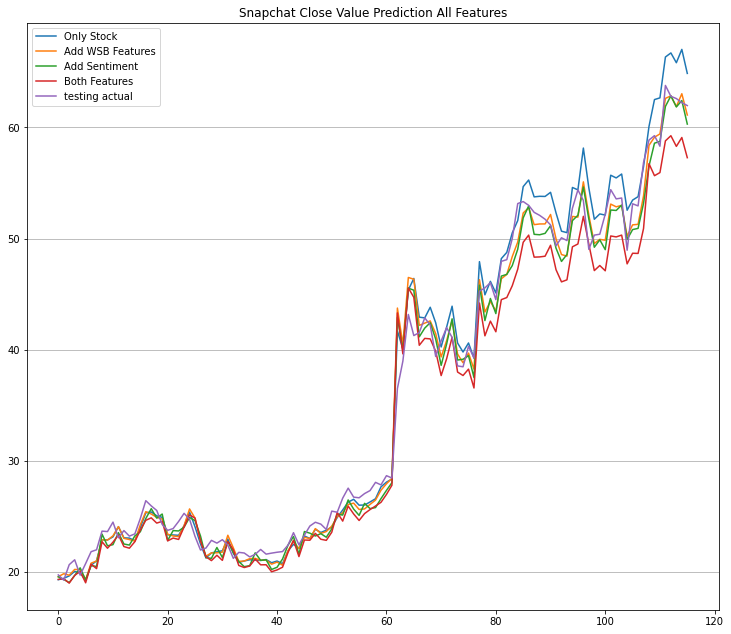

In [183]:
#display testing results
print('Root mean square error with Only Stock info is {}'.format(testScore_4))
print('Root mean square error with added WSB Features is {}'.format(testScore_2))
print('Root mean square error with added Sentiment is {}'.format(testScore_3))
print('Root mean square error with Both Features is {}'.format(testScore_1))

f = plt.figure()
f.set_figwidth(12.4)
f.set_figheight(10.8)
plt.plot(y_MinMax.inverse_transform(test_4),label='Only Stock')
plt.plot(y_MinMax.inverse_transform(test_2),label='Add WSB Features')
plt.plot(y_MinMax.inverse_transform(test_3),label='Add Sentiment')
plt.plot(y_MinMax.inverse_transform(test_1),label='Both Features')
plt.plot(y_MinMax.inverse_transform(y_test),label='testing actual')
plt.title('Snapchat Close Value Prediction All Features')
plt.legend()
plt.grid(axis = 'y')
plt.show()
plt.clf()
plt.cla()
plt.close()


Root mean square error of is 0.018499847413474053
Root mean square error of is 0.015459433326029764
Root mean square error of is 0.015811361394079796
Root mean square error of is 0.011580870343685308


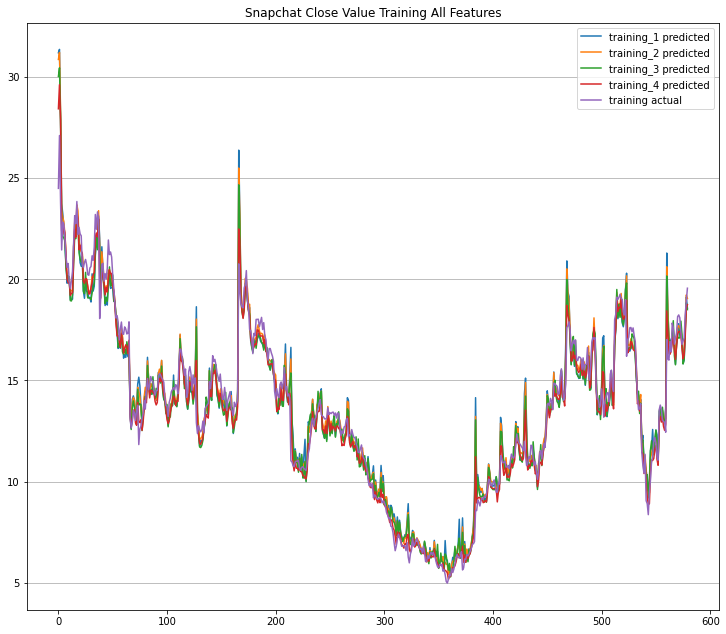

In [184]:
#Display Training Results
print('Root mean square error of is {}'.format(trainScore_1))
print('Root mean square error of is {}'.format(trainScore_2))
print('Root mean square error of is {}'.format(trainScore_3))
print('Root mean square error of is {}'.format(trainScore_4))

f = plt.figure()
f.set_figwidth(12.4)
f.set_figheight(10.8)
plt.plot(y_MinMax.inverse_transform(train_1),label='training_1 predicted')
plt.plot(y_MinMax.inverse_transform(train_2),label='training_2 predicted')
plt.plot(y_MinMax.inverse_transform(train_3),label='training_3 predicted')
plt.plot(y_MinMax.inverse_transform(train_4),label='training_4 predicted')
plt.plot(y_MinMax.inverse_transform(y_train),label='training actual')
plt.title('Snapchat Close Value Training All Features')
plt.legend()
plt.grid(axis = 'y')
plt.show()
plt.clf()
plt.cla()
plt.close()
